In [16]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from gPhoton.galextools import mag2counts
plt.rcParams.update({'font.size': 18})

In [2]:
# Import the function definitions that accompany this notebook tutorial.
nb_funcdef_file = "function_defs.py"
if os.path.isfile(nb_funcdef_file):
    from function_defs import get_inff, calculate_flare_energy, refine_flare_ranges
else:
    raise IOError("Could not find function definition file '" + nb_funcdef_file + "' that goes with this notebook.")

In [3]:
# Import the function definitions that accompany this notebook tutorial.
nb_recoverydef_file = "recovery_defs.py"
if os.path.isfile(nb_recoverydef_file):
    from recovery_defs import fake_a_flare, calculate_ideal_flare_energy, inject_and_recover
else:
    raise IOError("Could not find recovery definition file '" + nb_recoverydef_file + "' that goes with this notebook.")

In [4]:
# Restore the distance parameter.  Note: this assumes you've run the "generate_products" notebook already.  If not you
# will need to specify the distance to use.
%store -r distance
# If you have not run the "generate_products" notebook during this session, uncomment the line below and specify
# the distance to the system in parsecs.
distance = 1/(372.1631/1000) # parsecs

no stored variable or alias distance


In [5]:
# Define some parameters for our recovery tests.
band = 'NUV'
binsize = 30.
quiescent_mag = 18. # approx. NUV mag of UV Ceti
trange = [0., 1600.] # nominal GALEX visit start and end, in seconds
resolution = 0.05 # photon time resolution in seconds
detection_threshold = 3. # min. detection threshold allowed for a flare to be considered "detected", measured in sigma
max_flares_pervisit = 3 # max. number of flares to occur within a given Visit

Let's generate some synthetic flares and compare the energies measured by our flare finding algorithm with the known
values.  This is to demonstrate what a few of the synthetic flares look like and what the fits to them look like. The full simulation is done later.

In [6]:
def within_factor(x, y, fact):
    # Returns True if x and y are within a factor of 'fact' from each other.
    if x >= y:
        return x / y <= fact
    else:
        return y / x <= fact

<ipython-input-8-a55aec1aa58f>:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 3), sharex=True)


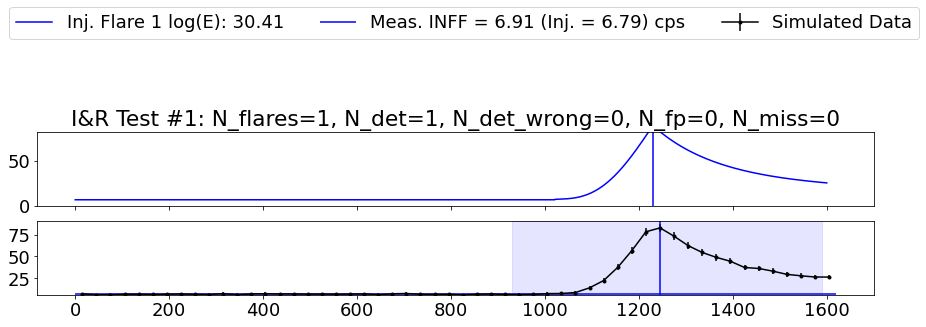

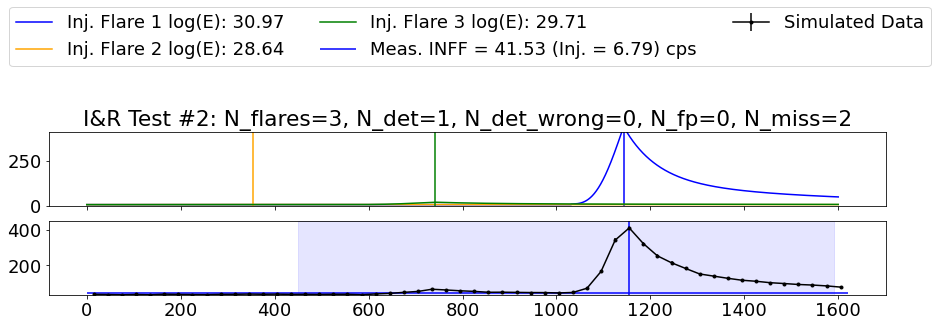

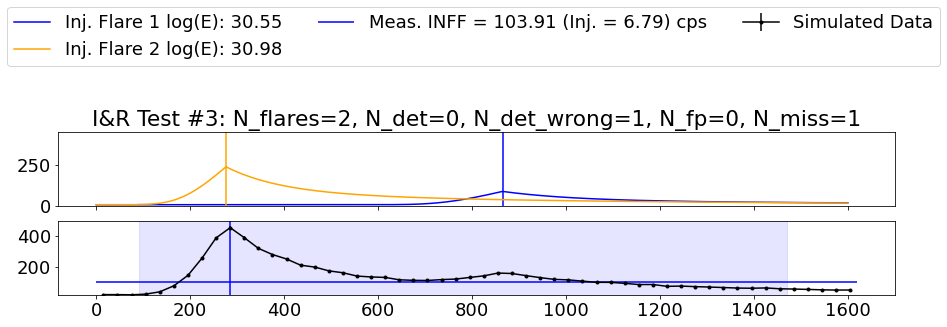

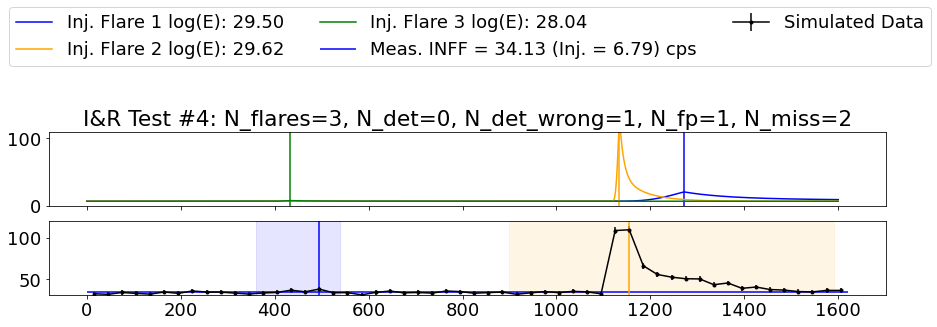

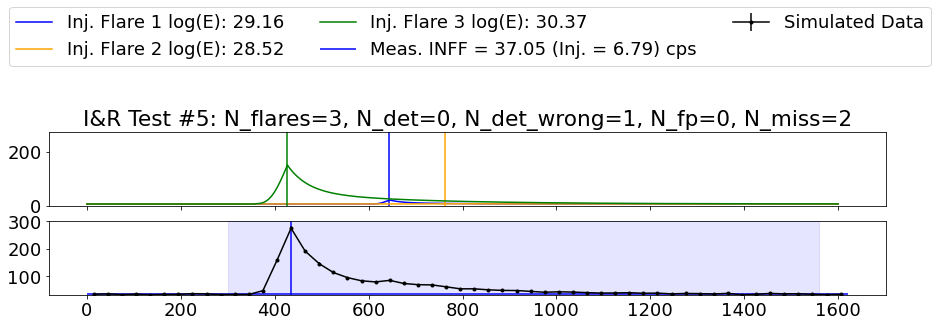

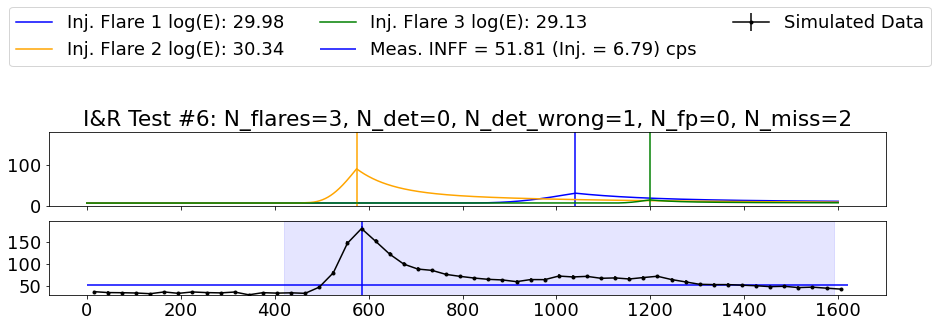

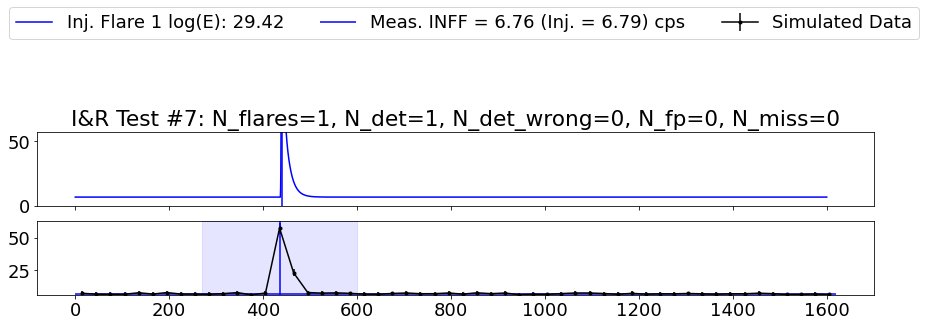

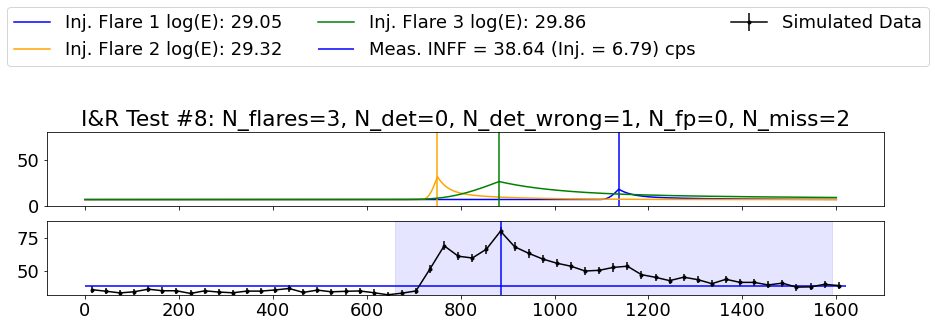

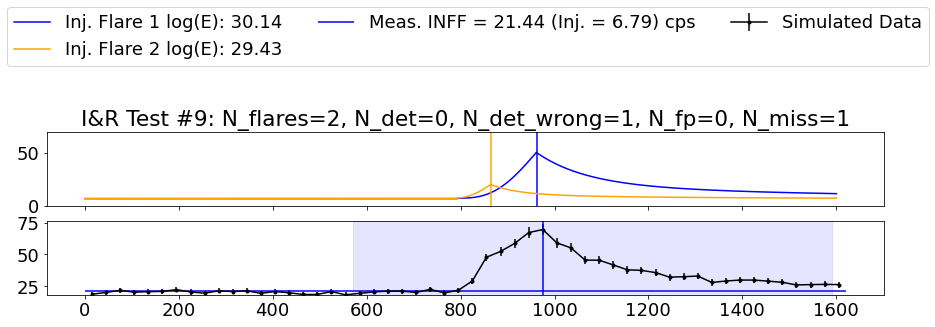

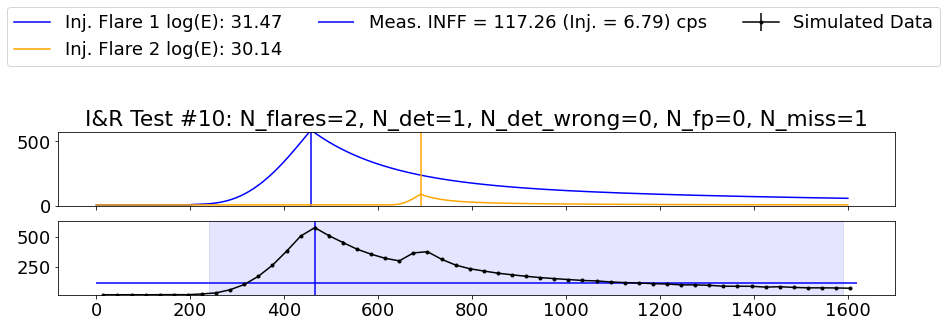

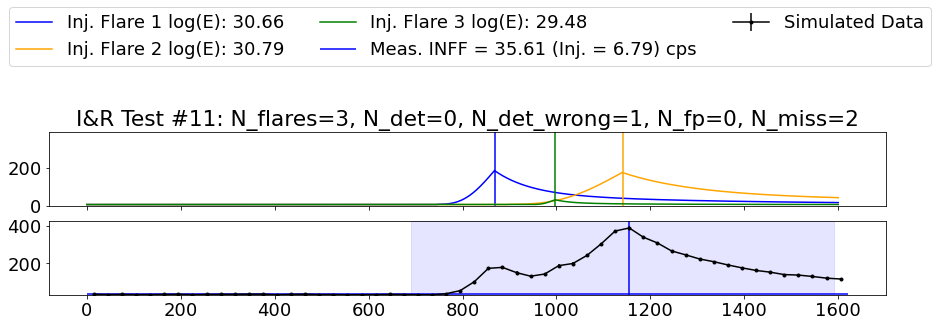

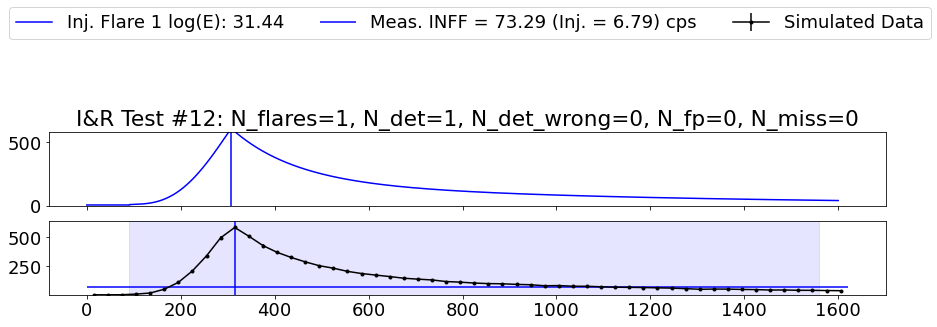

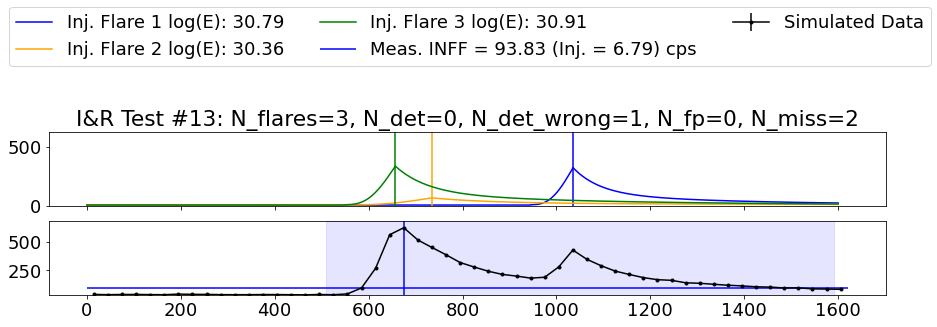

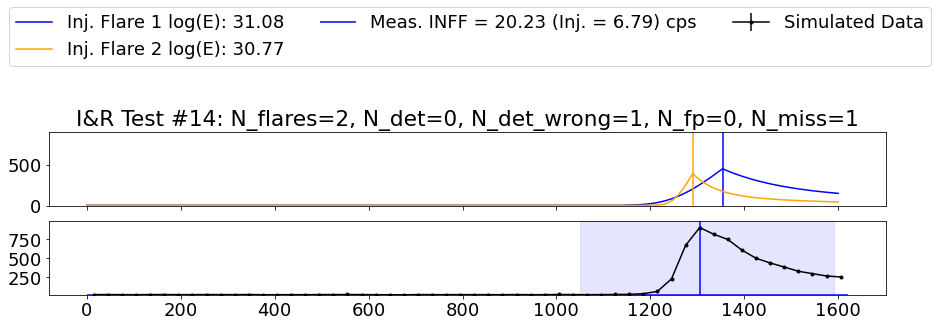

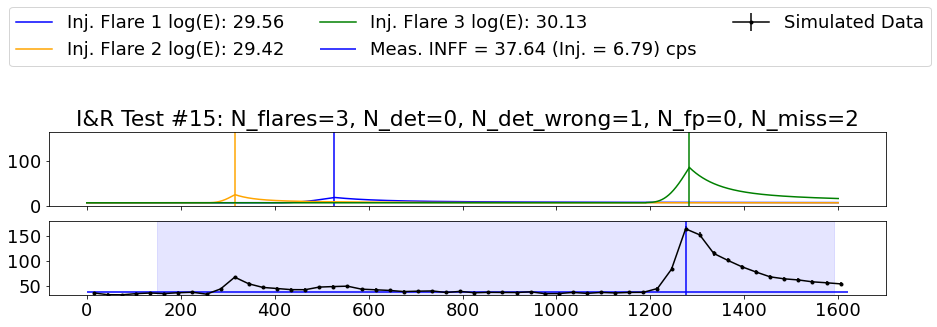

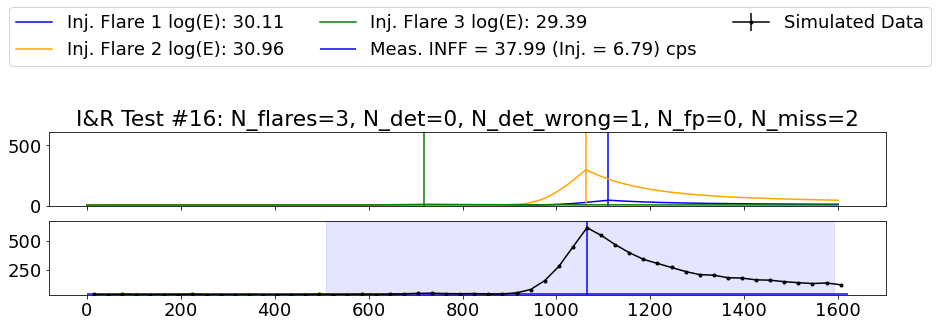

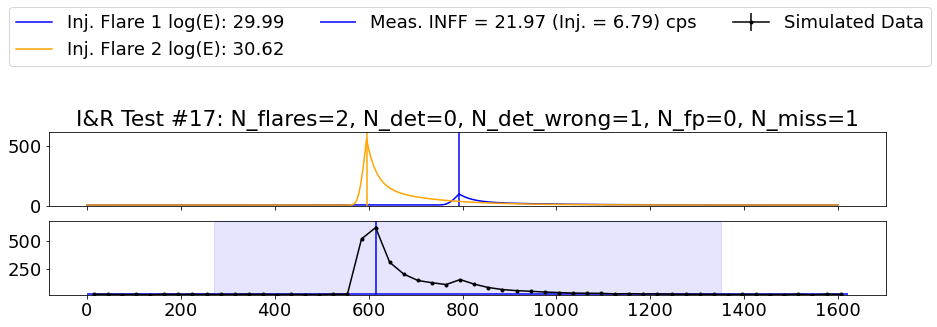

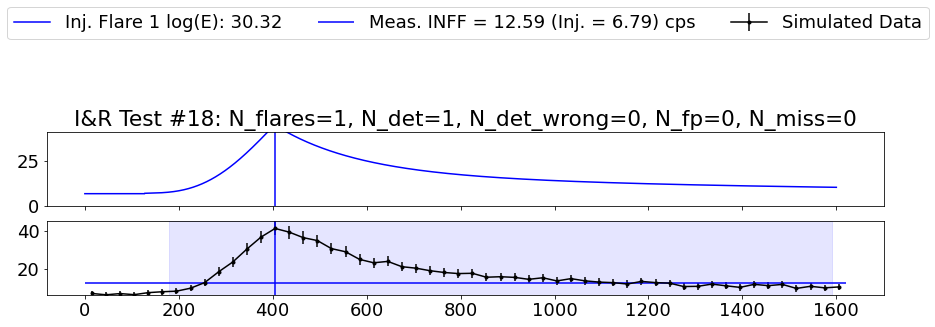

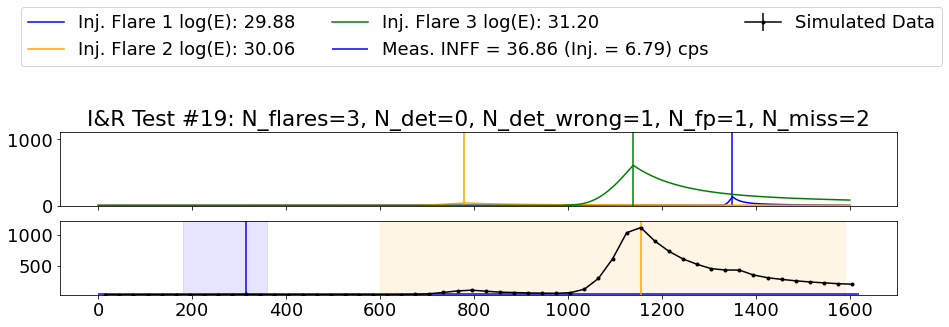

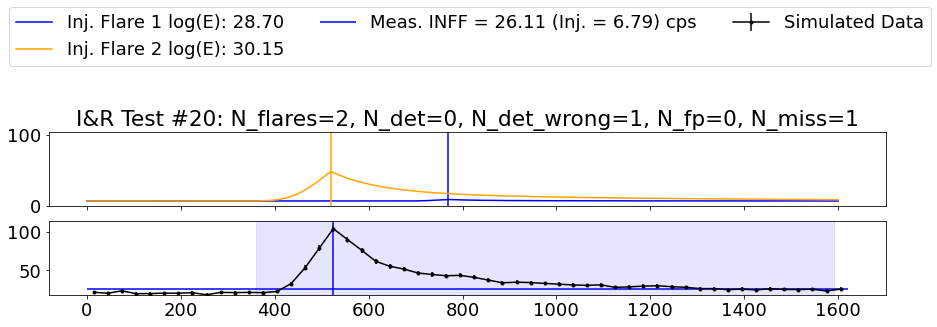

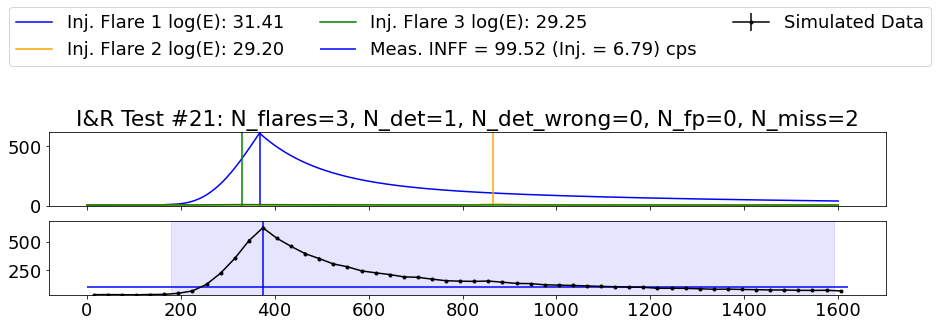

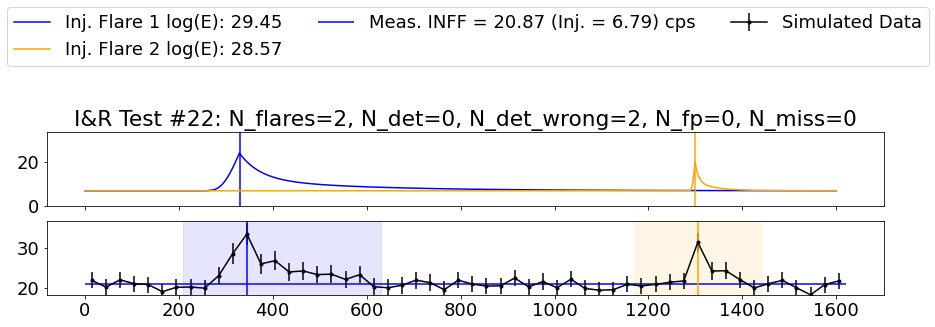

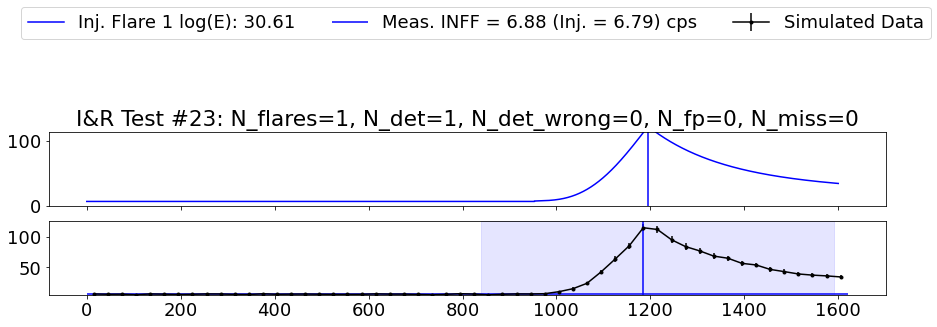

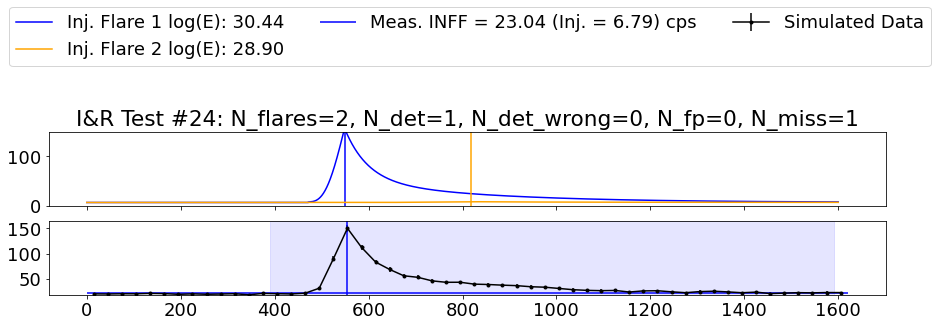

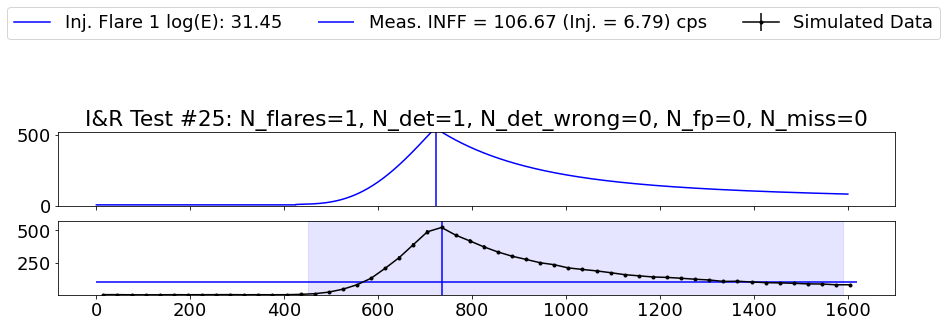

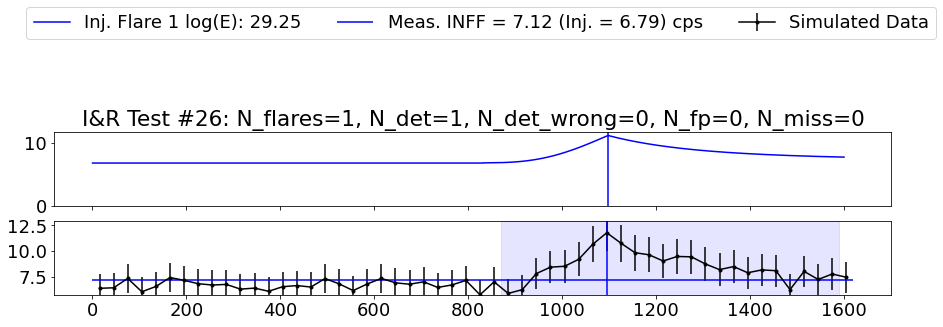

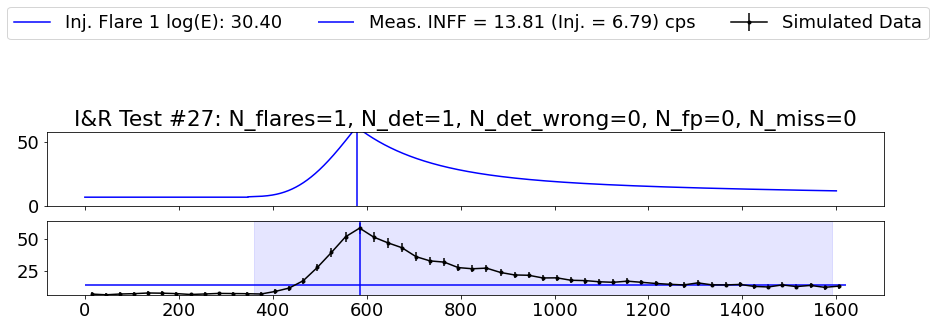

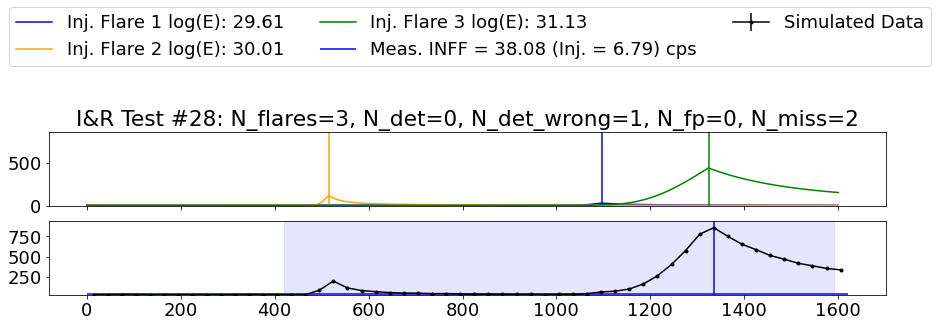

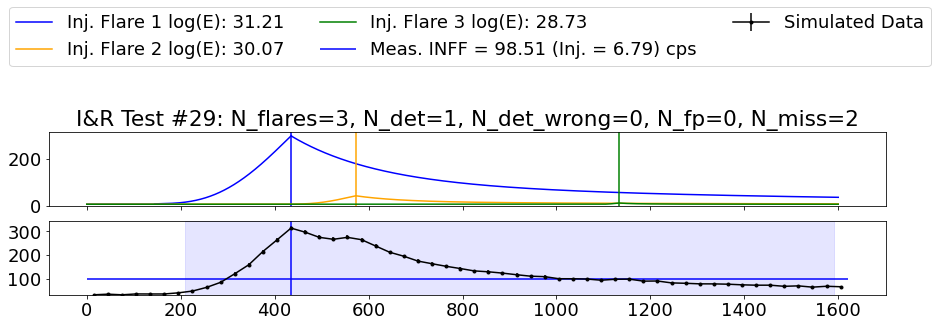

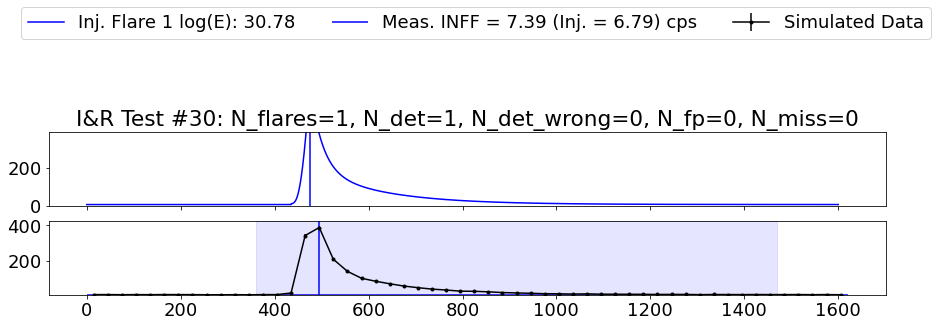

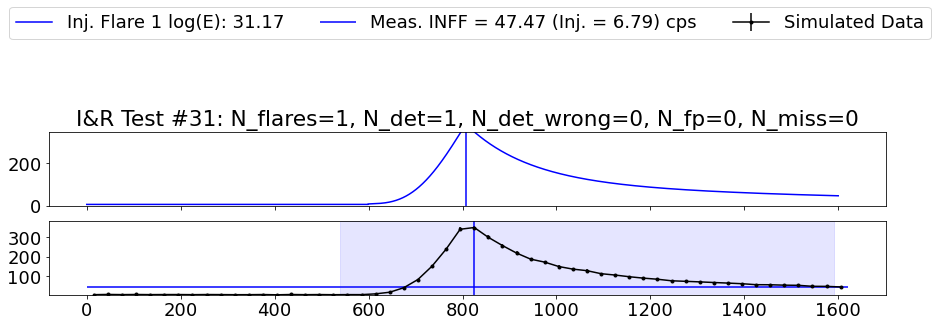

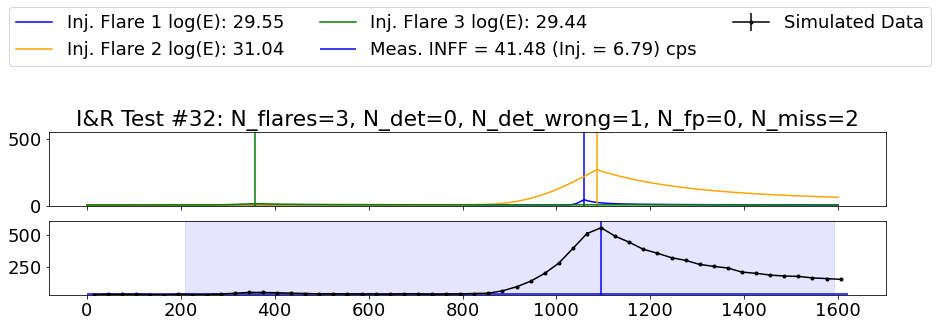

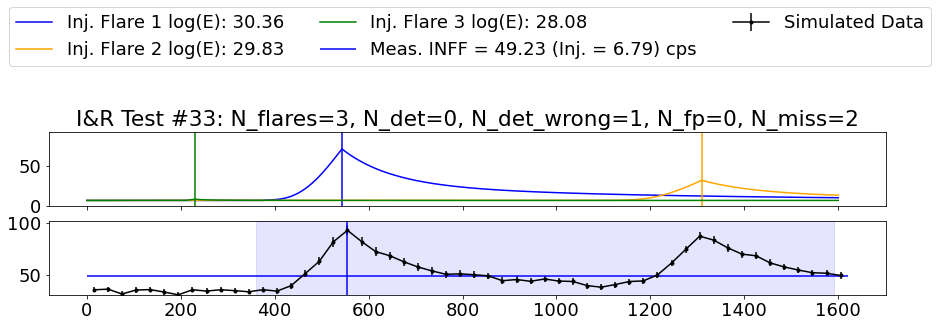

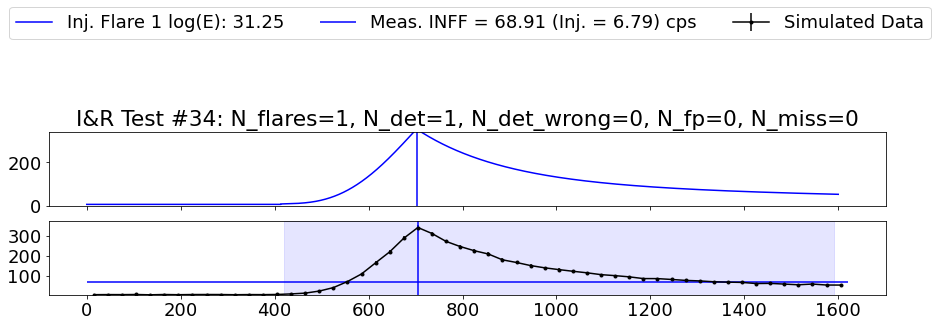

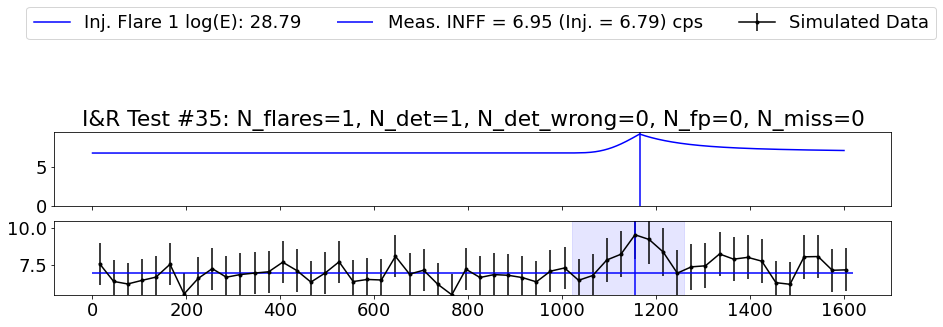

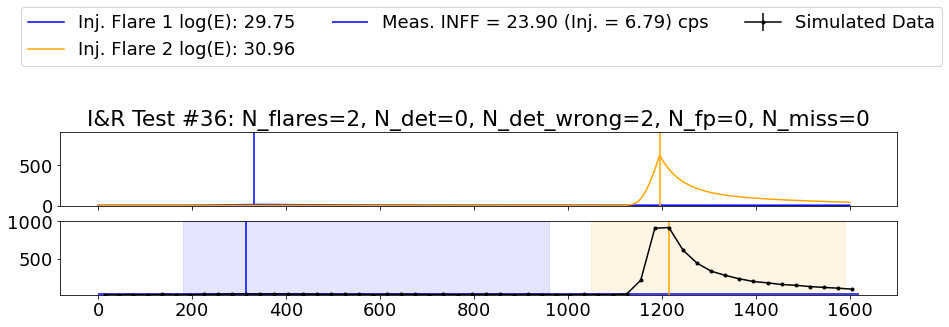

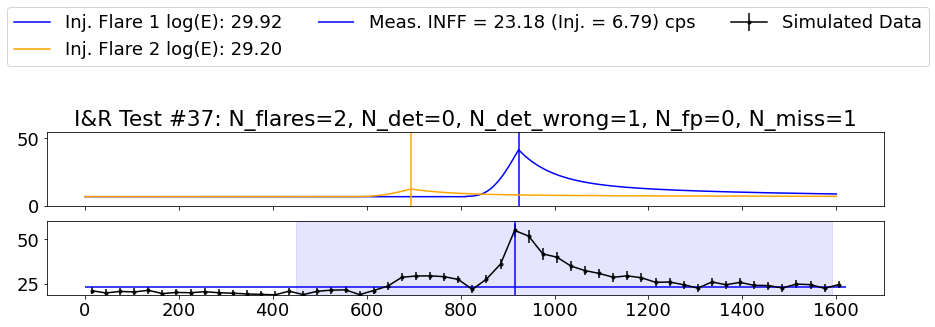

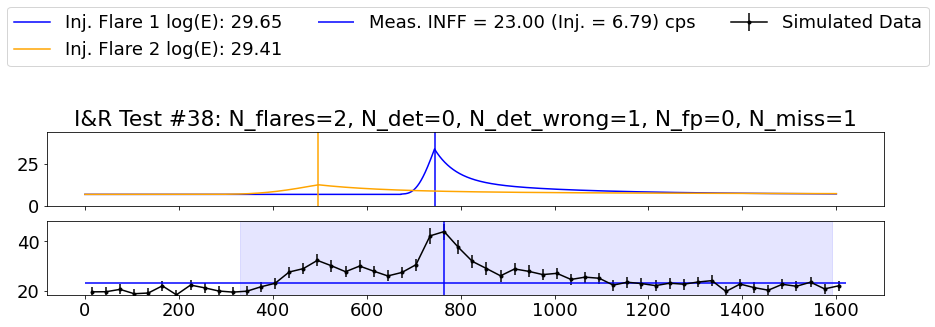

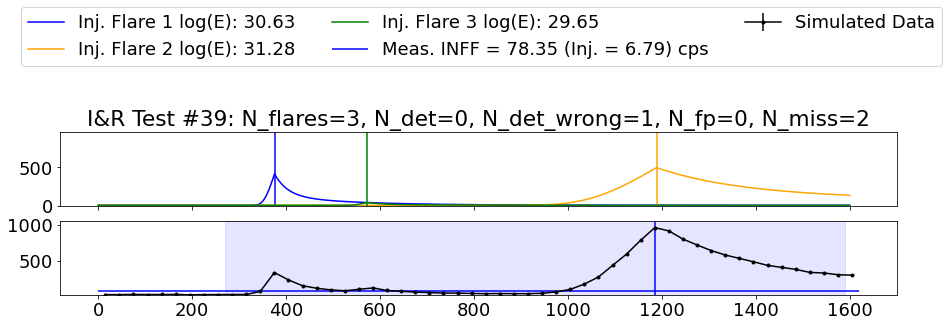

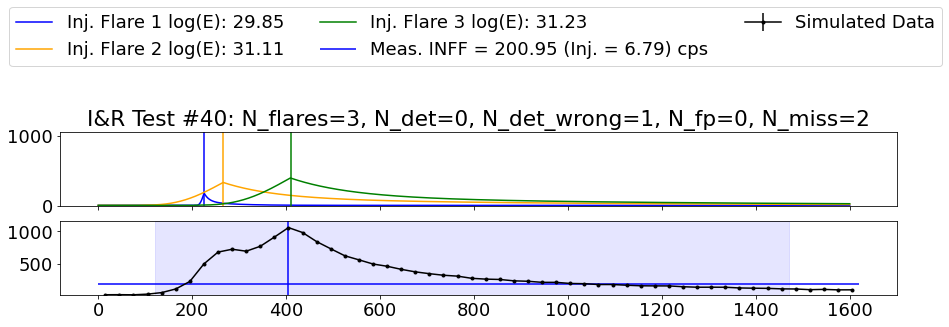

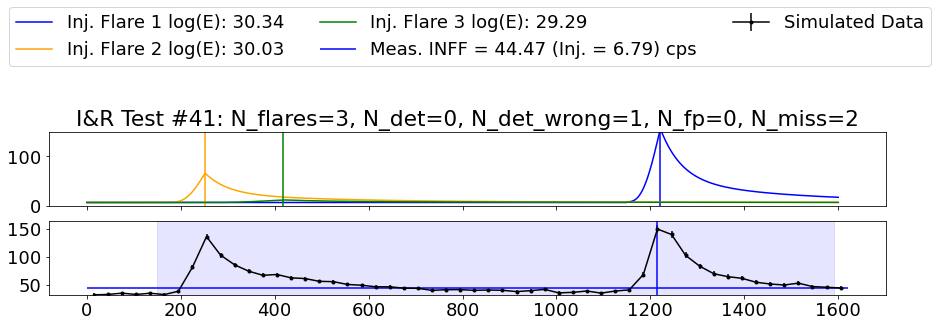

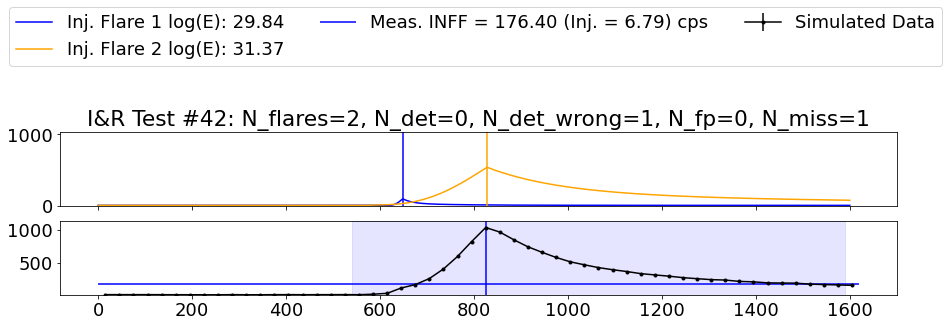

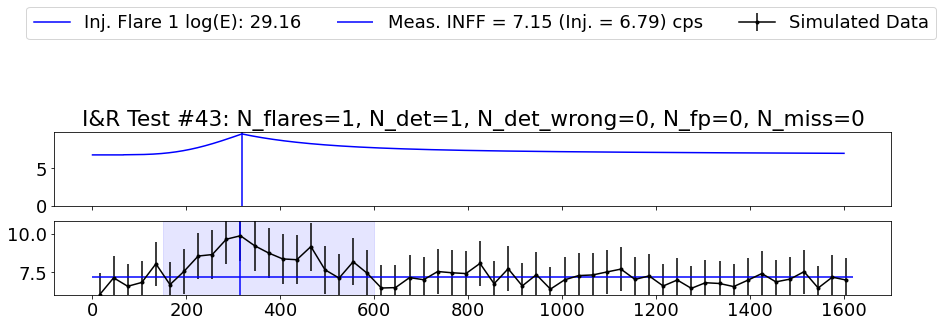

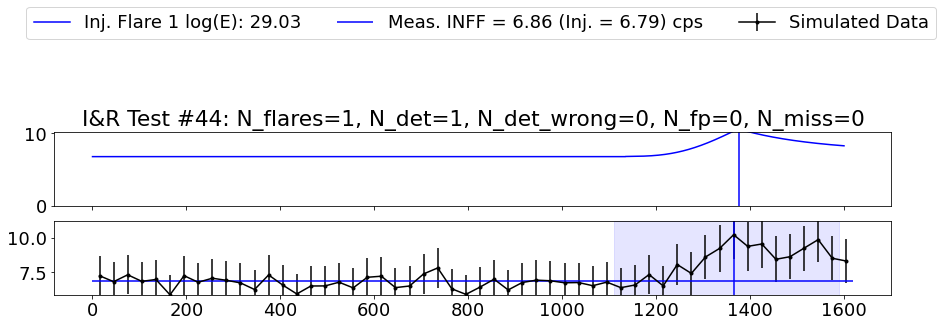

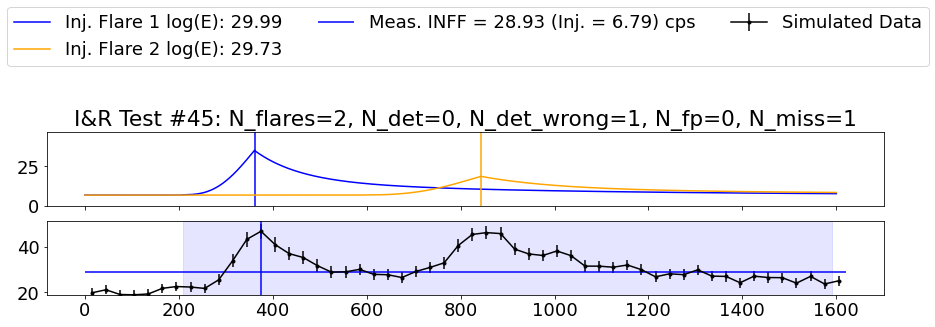

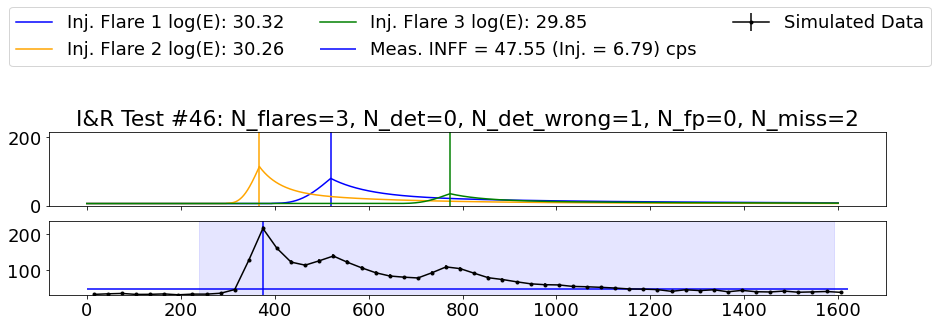

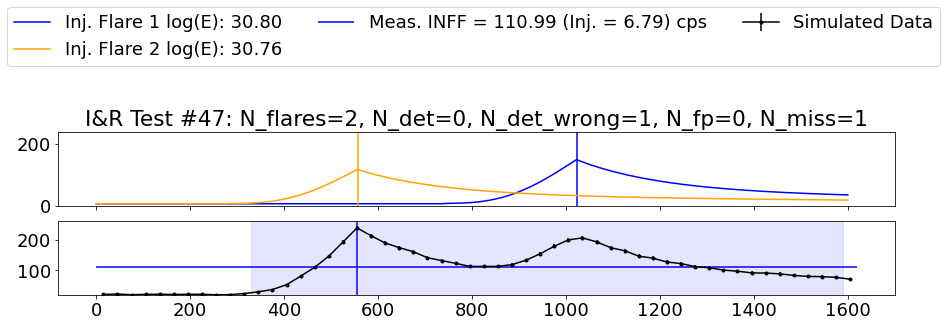

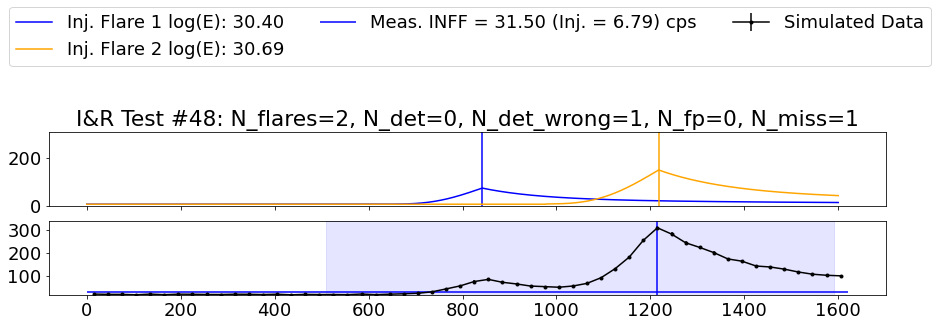

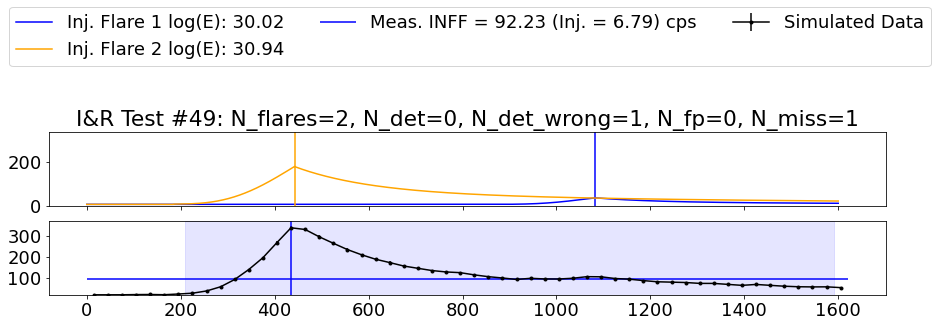

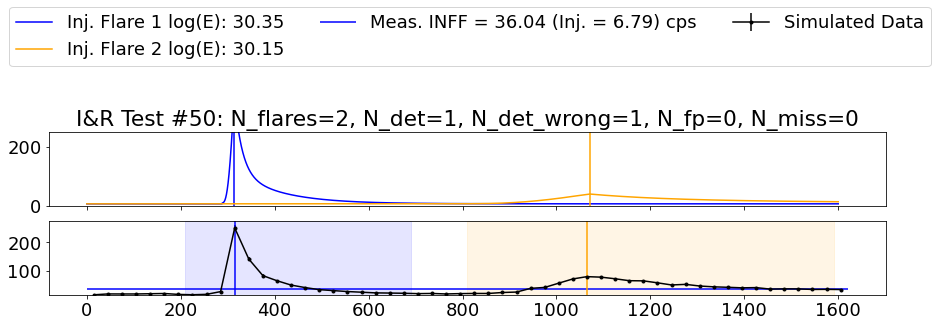

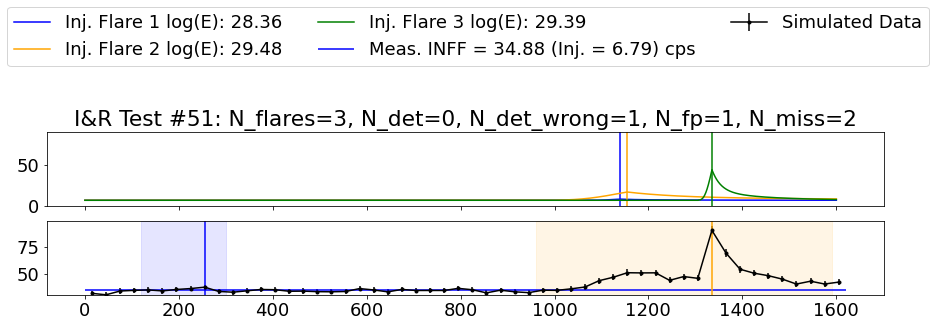

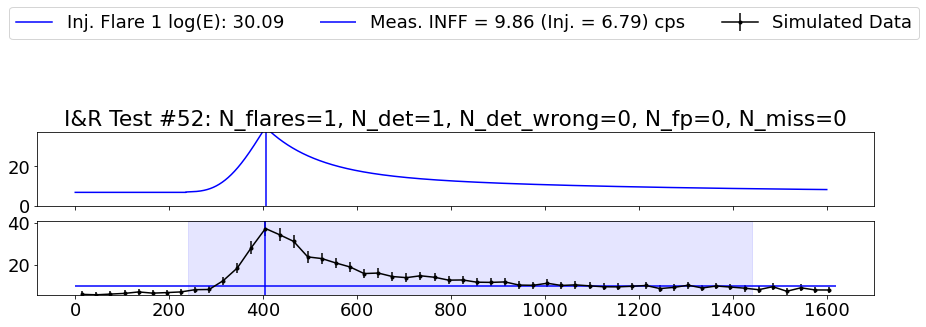

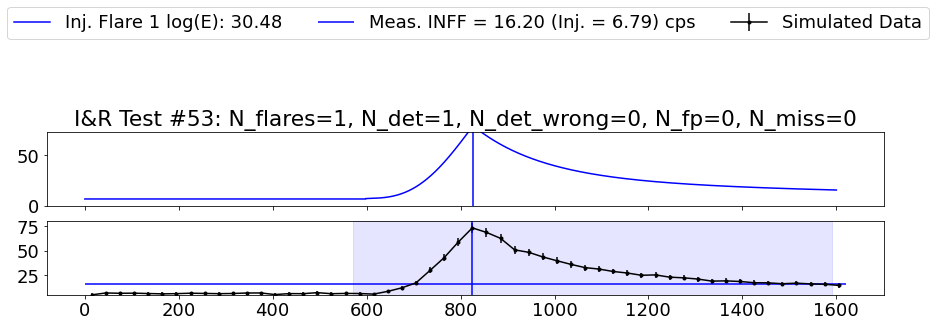

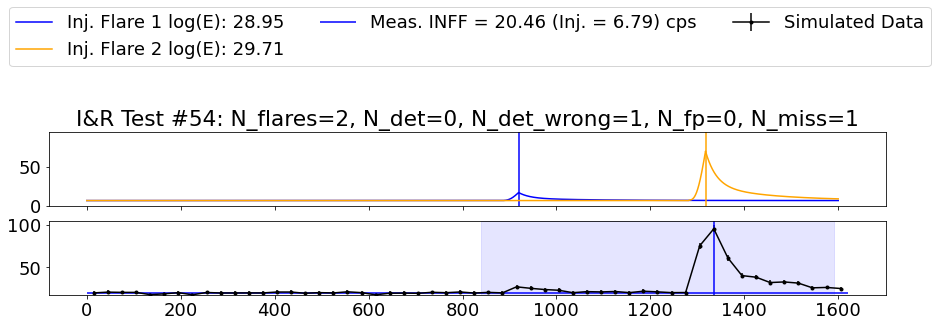

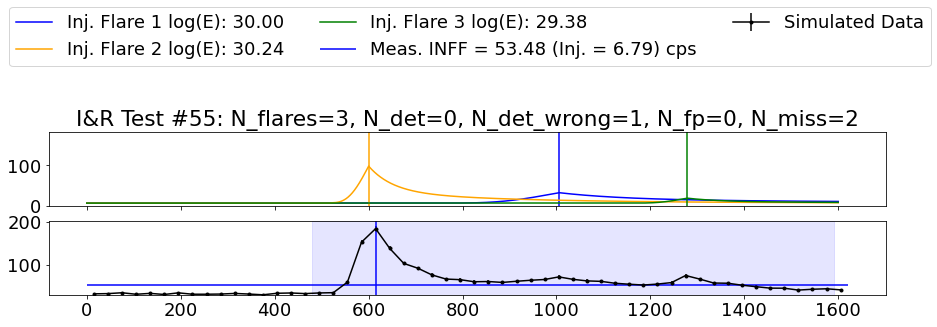

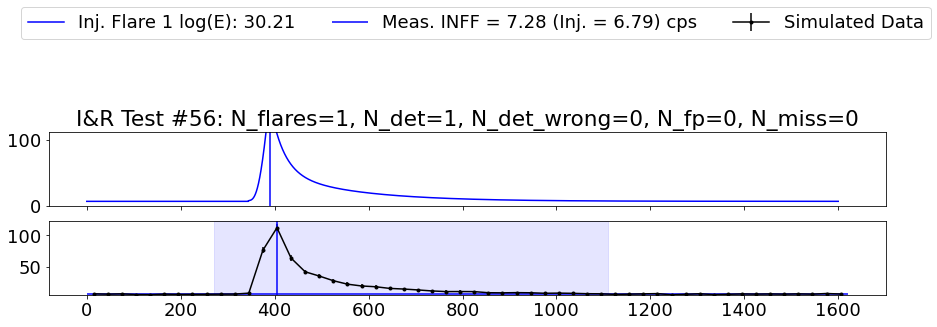

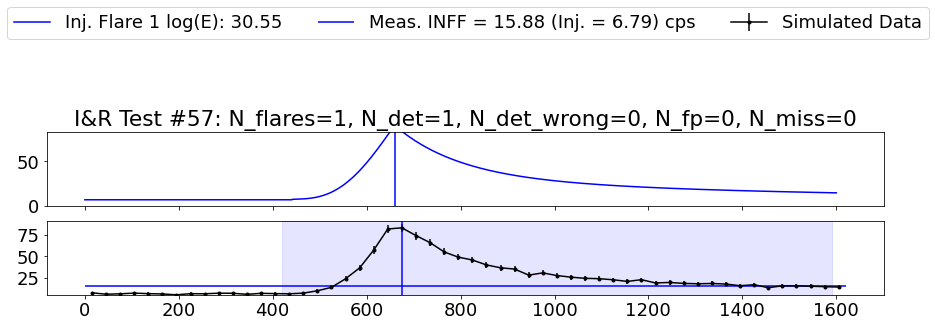

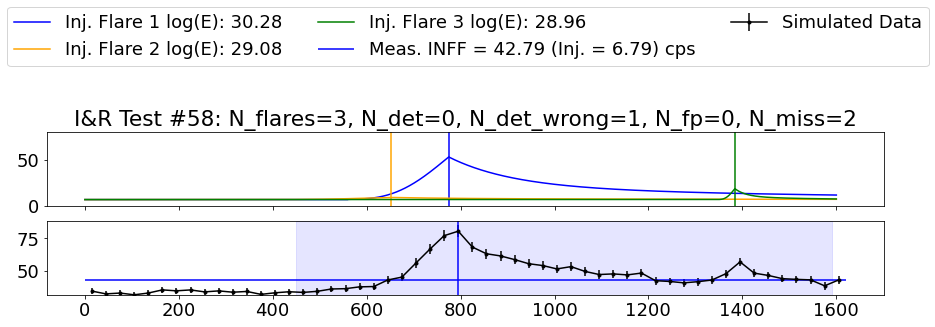

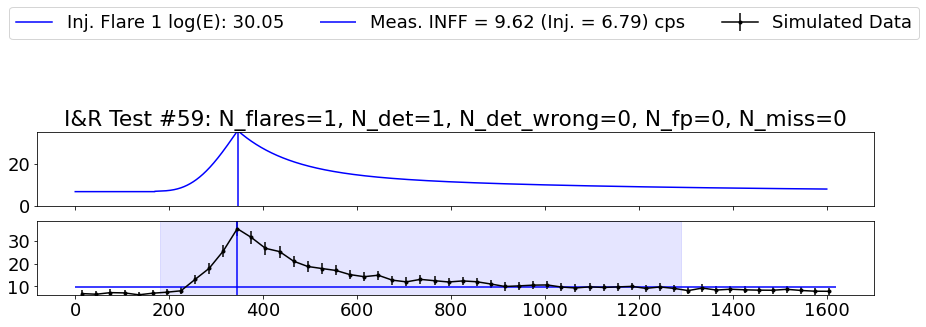

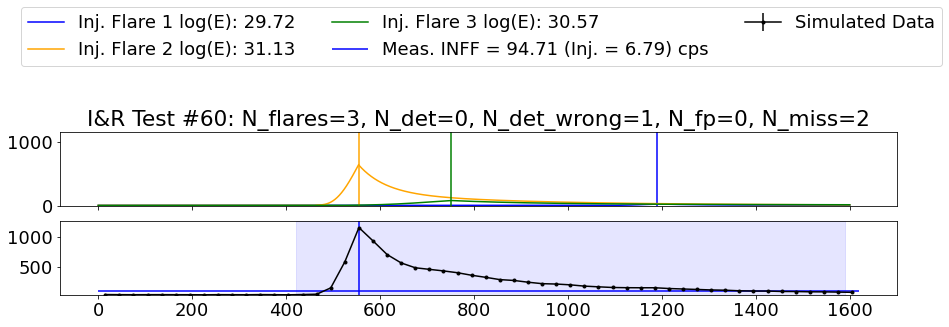

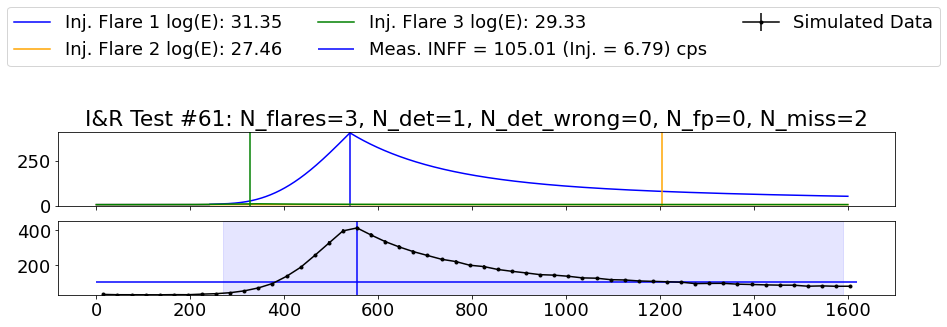

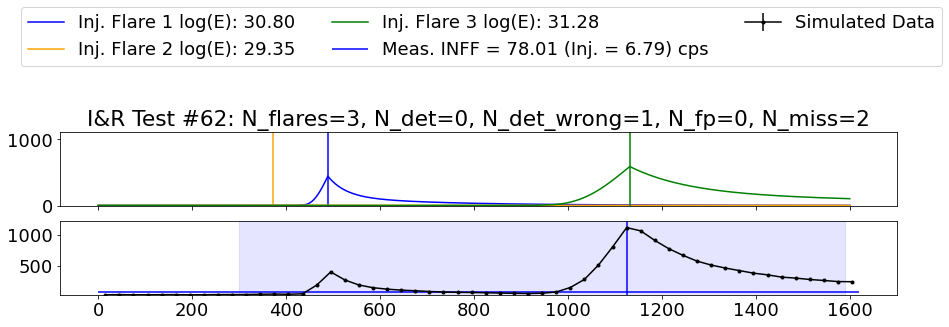

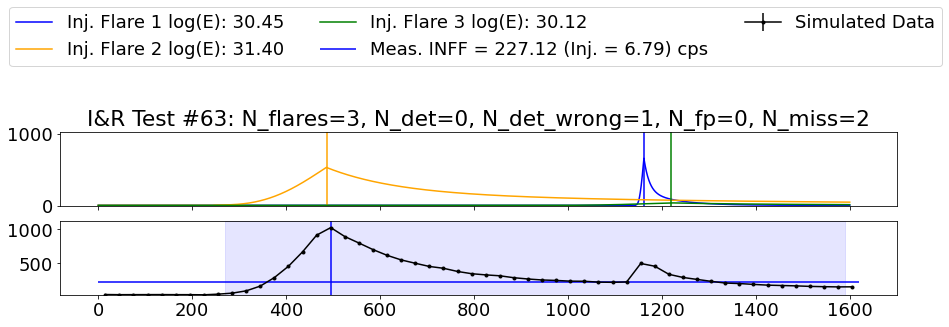

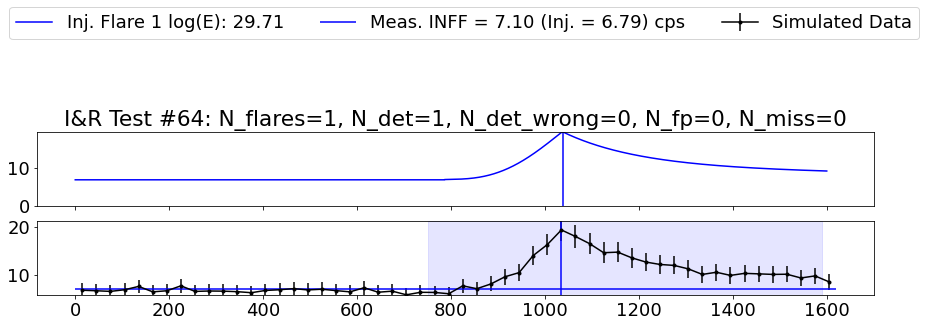

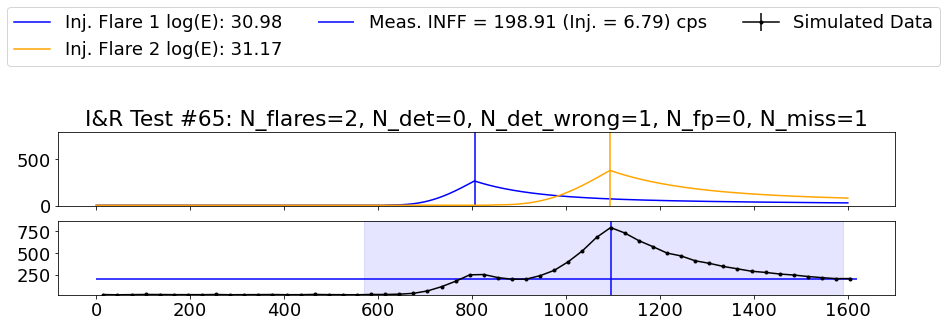

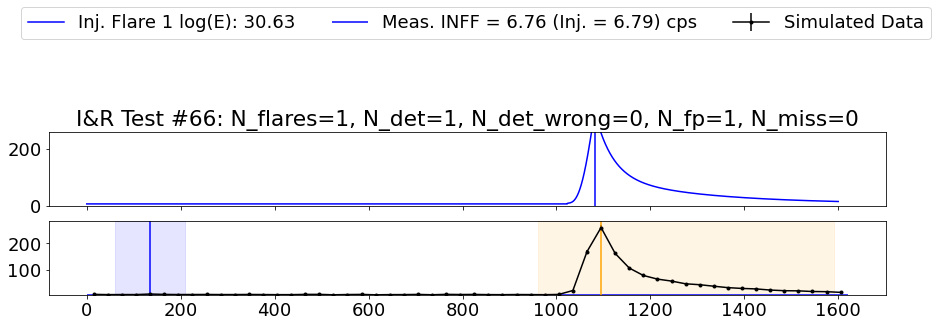

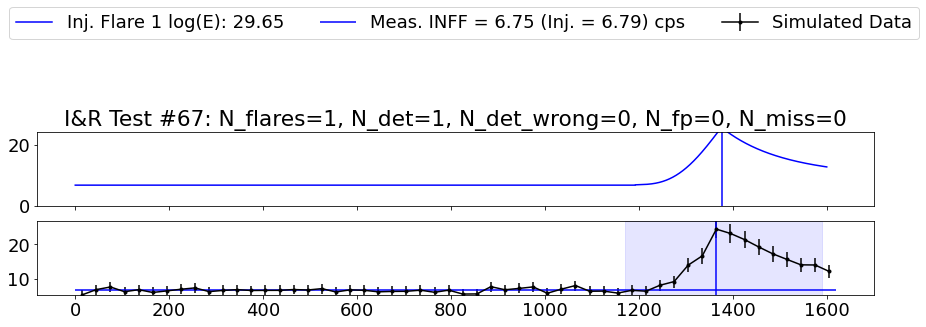

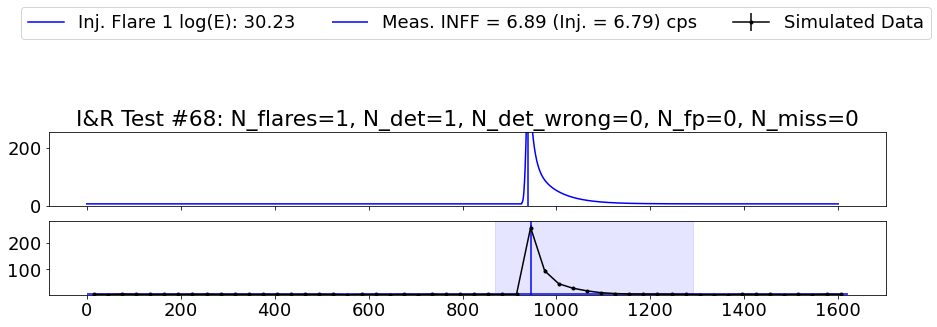

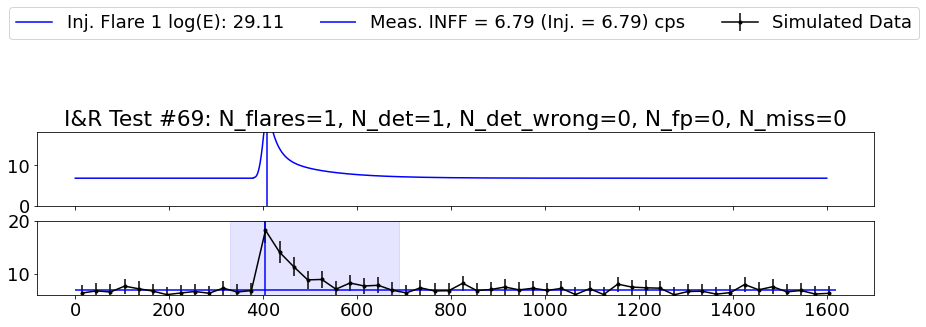

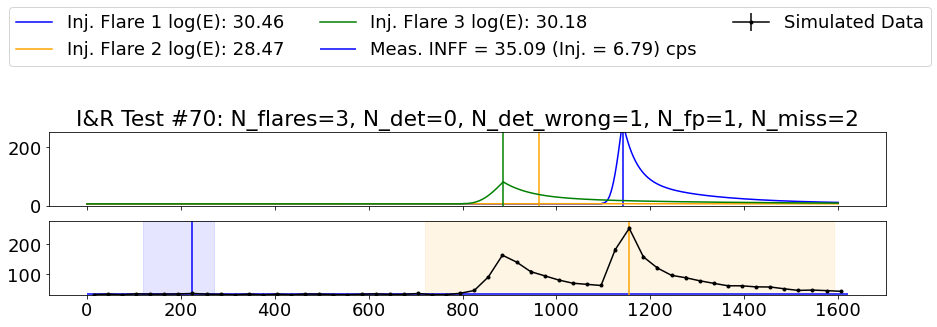

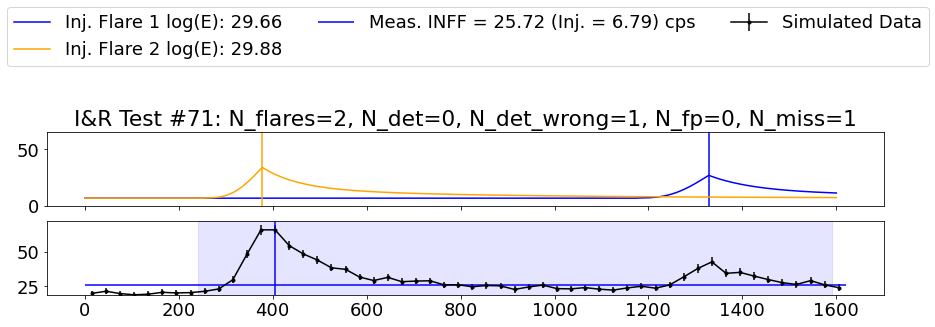

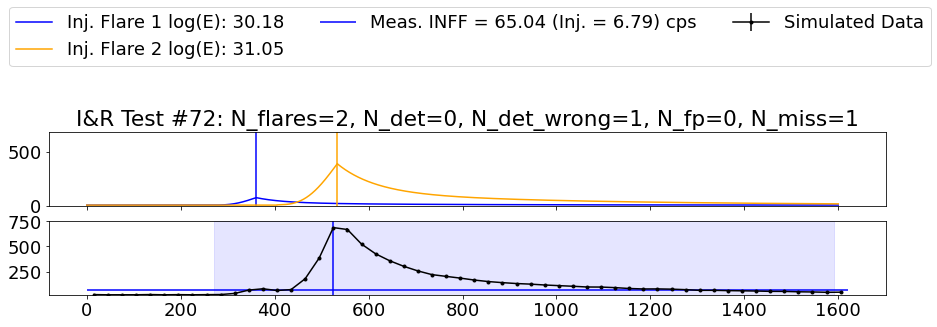

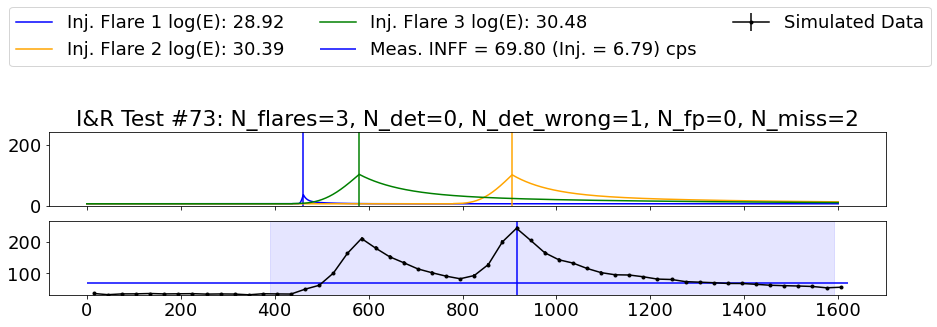

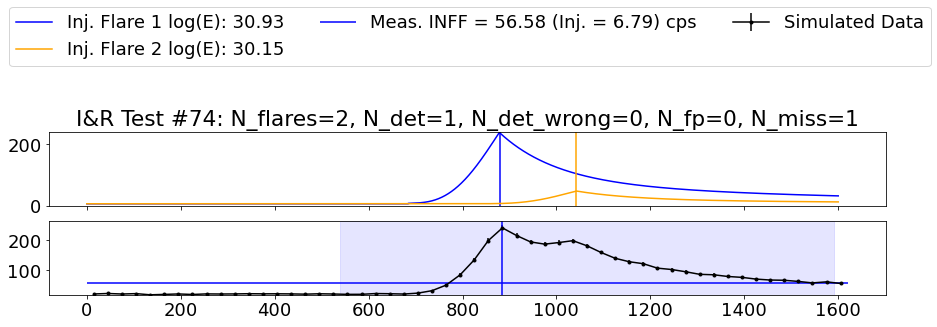

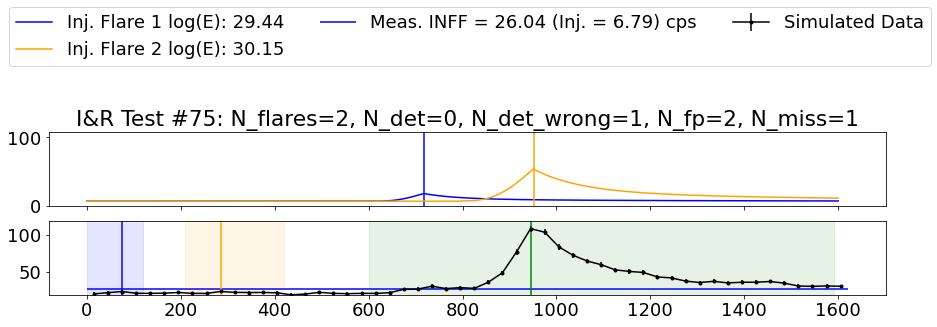

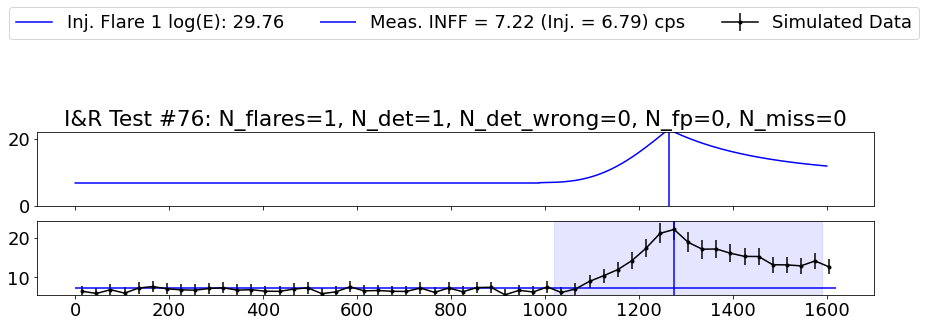

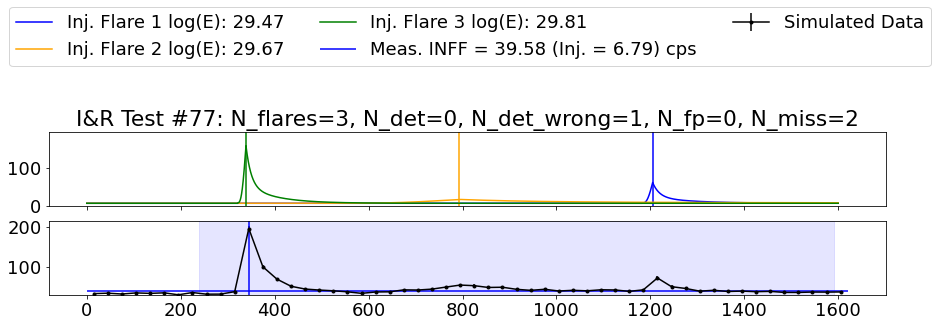

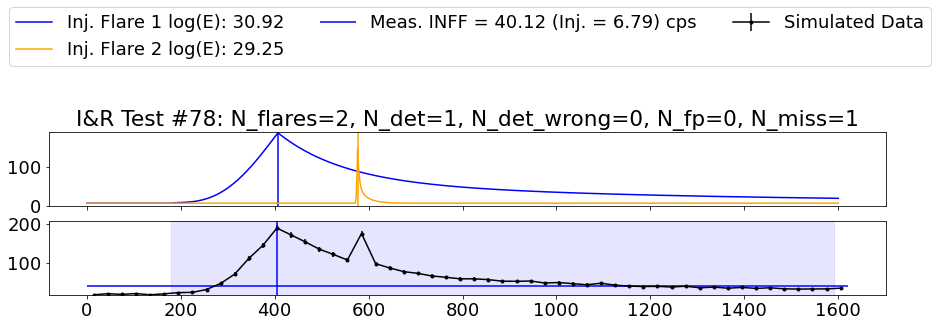

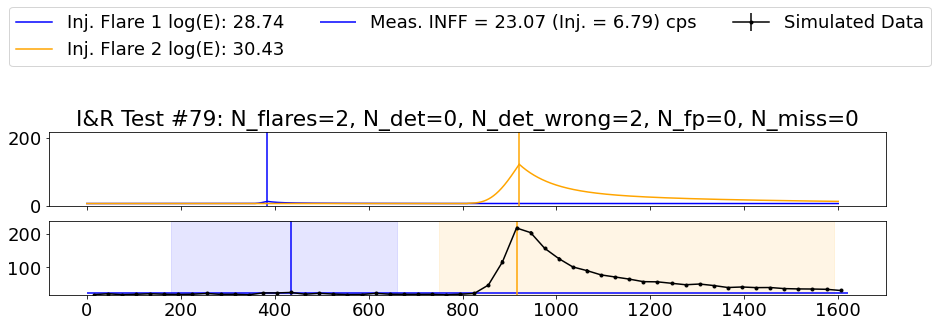

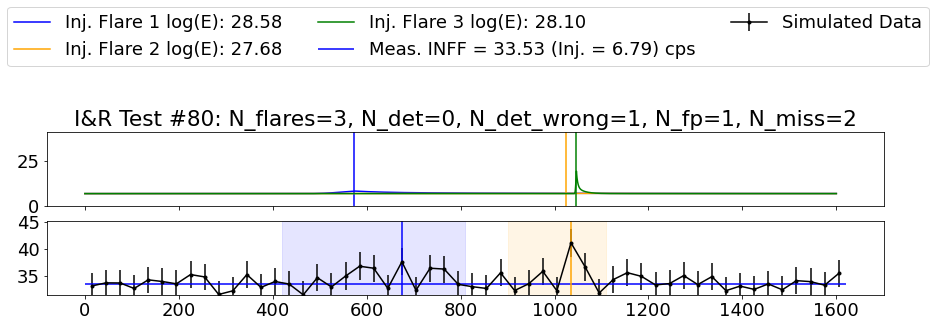

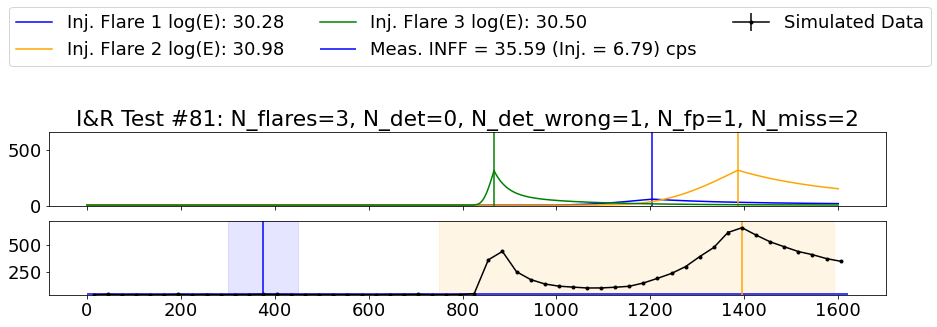

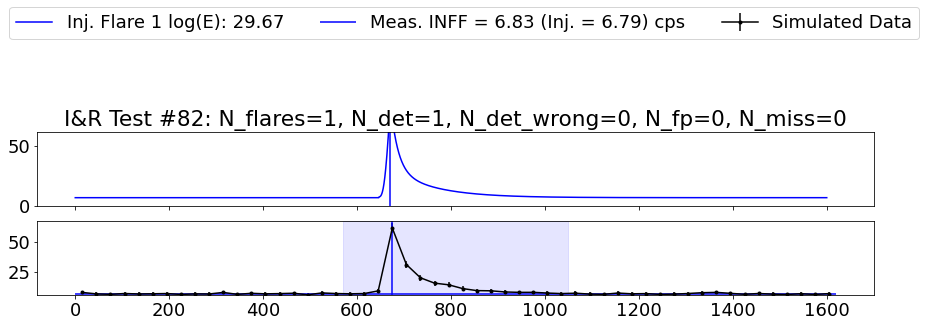

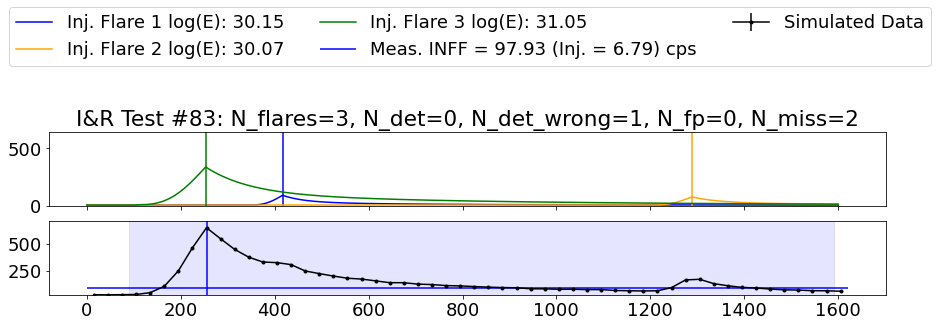

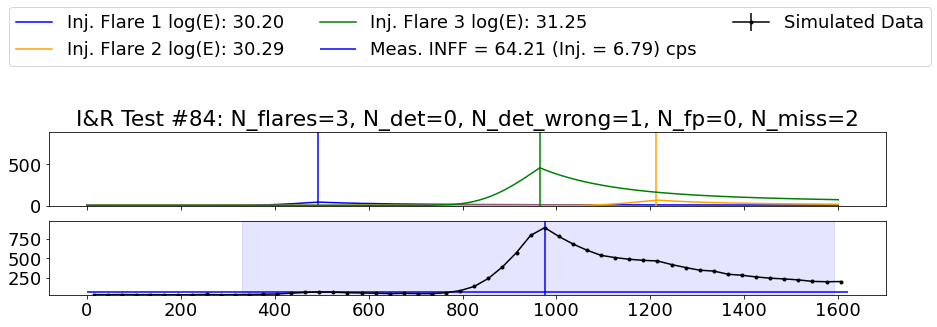

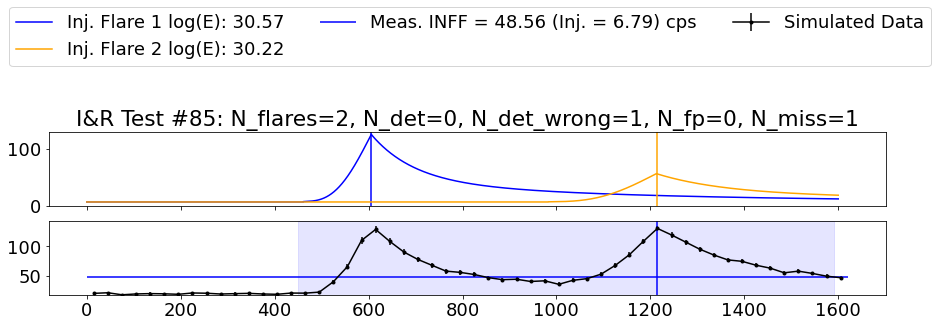

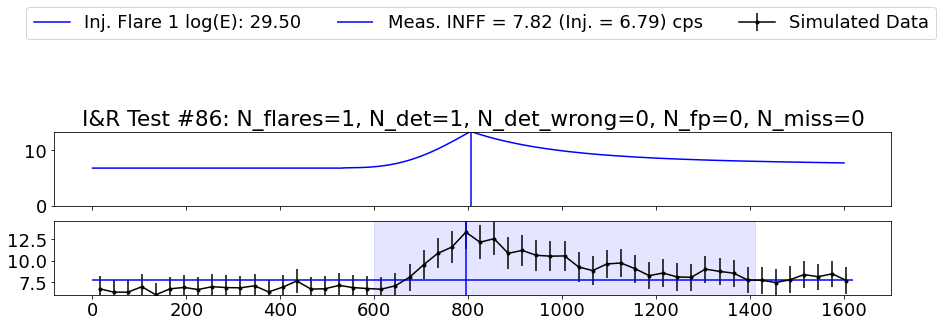

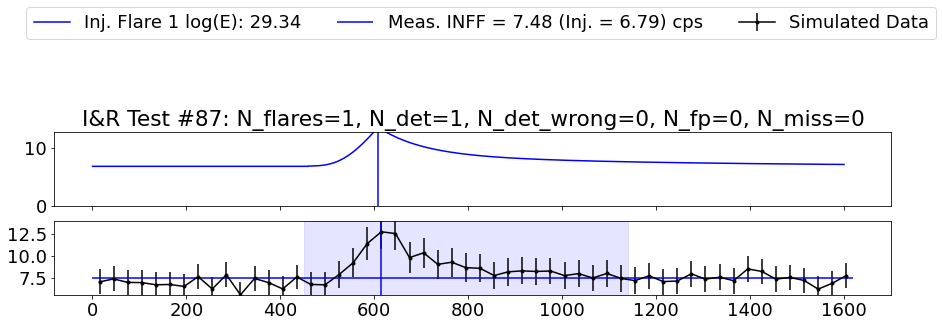

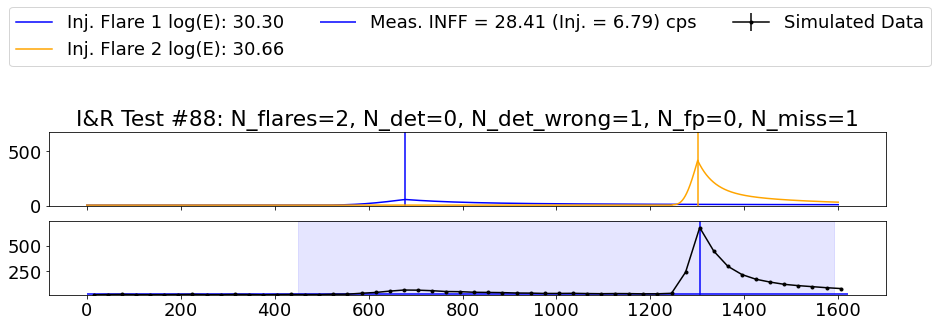

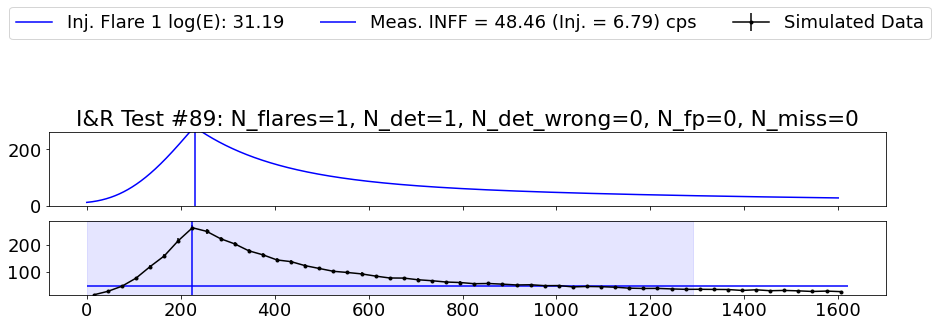

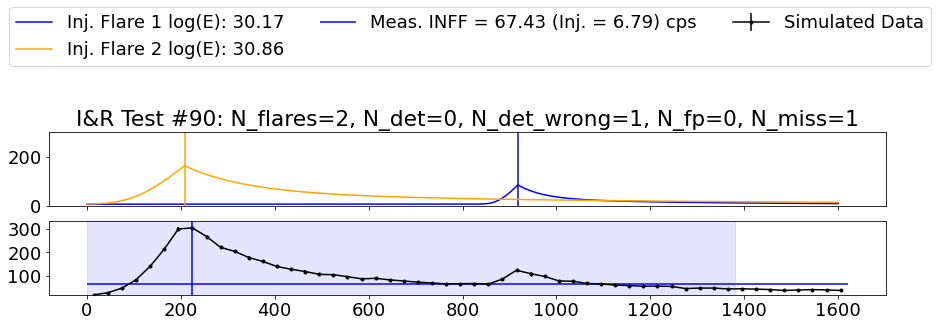

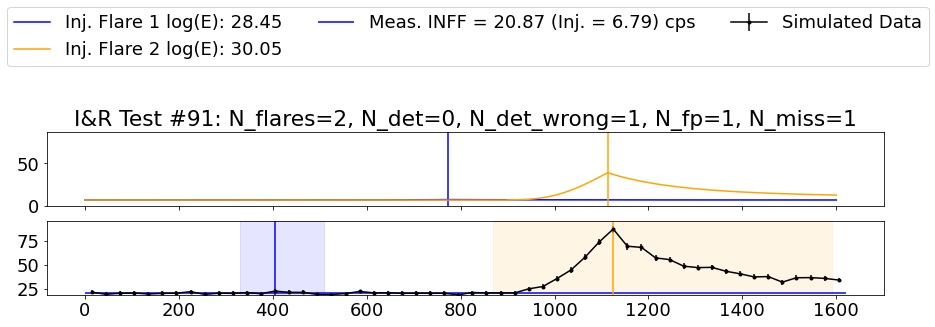

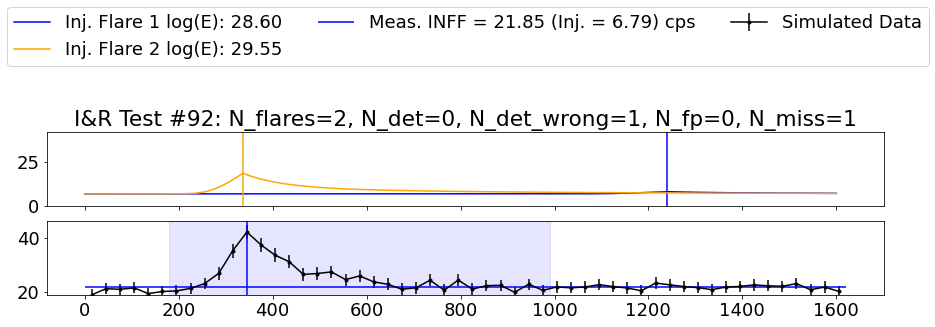

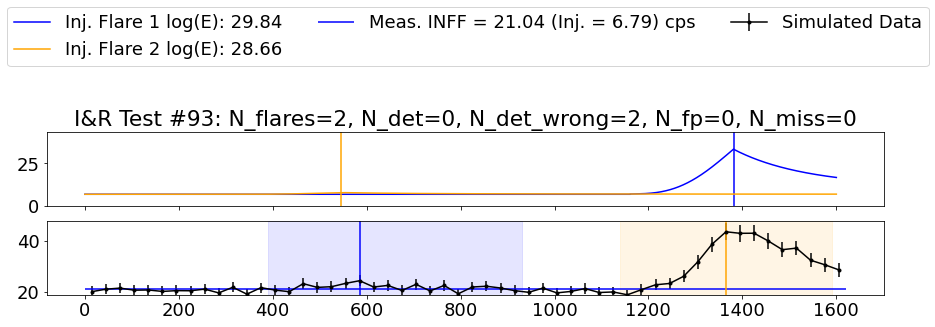

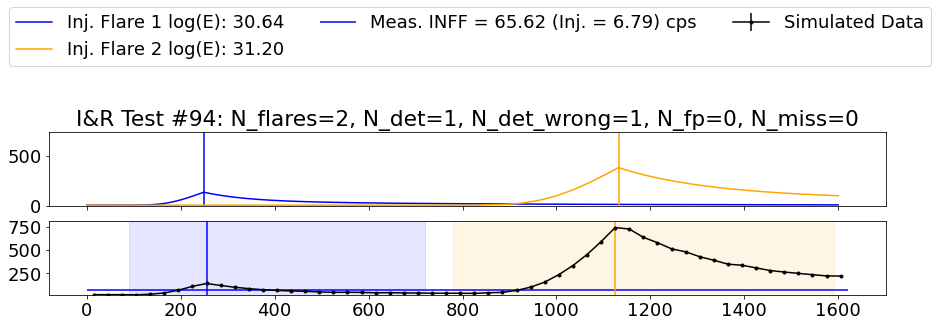

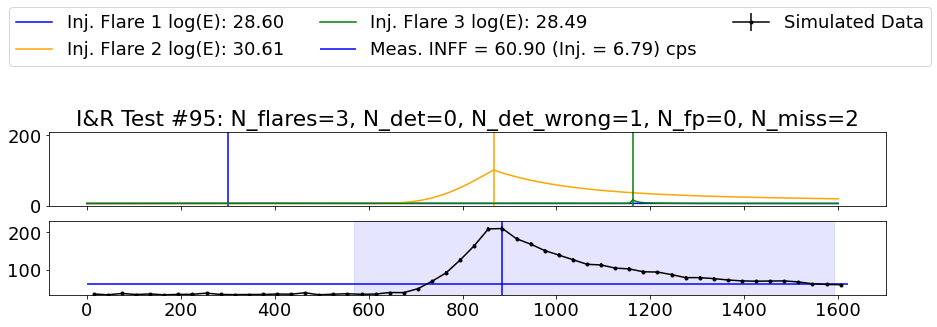

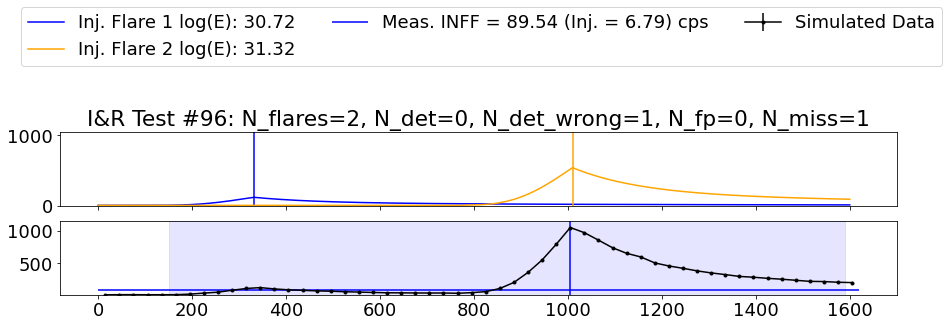

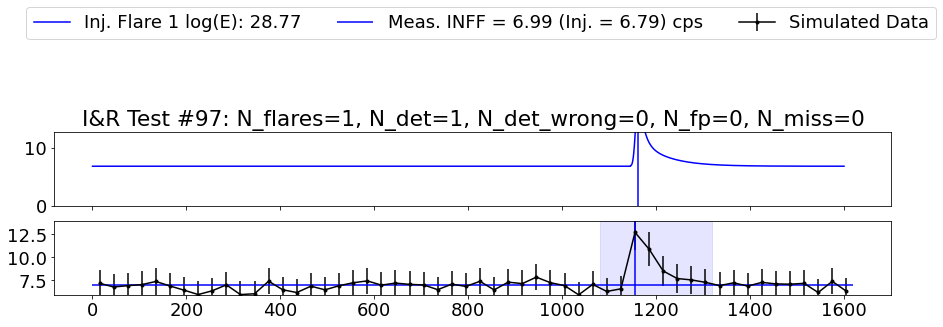

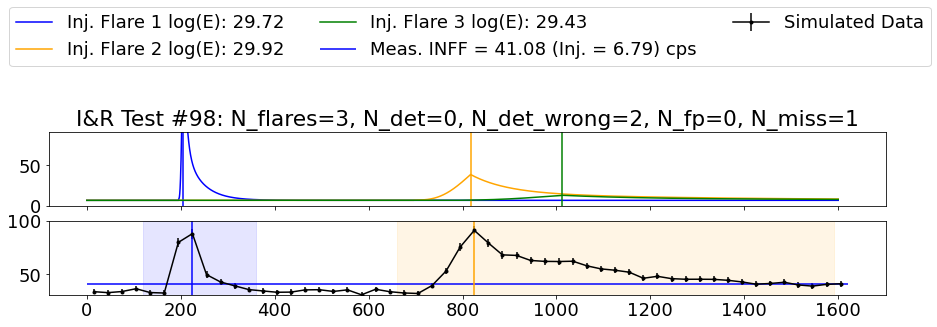

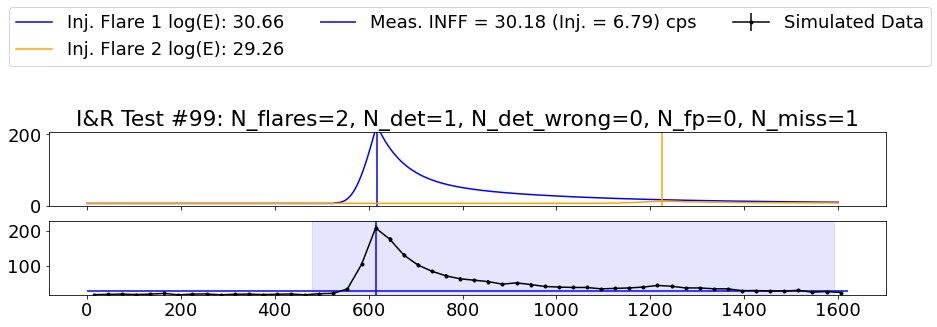

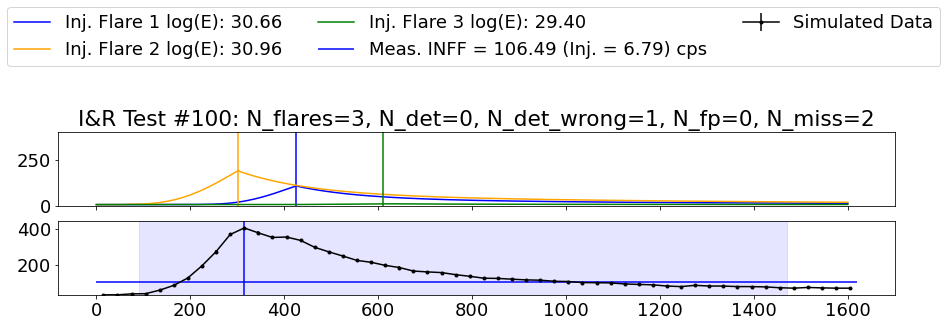

In [8]:
random_seed = 42 # So that the exact results here when selecting random flare properties are repeatable.
rng = np.random.default_rng(seed=random_seed)
# How many flares to simulate here as an overview.
n_flares_to_make = 100
# For each light curve, keep track of the number of flares detected, missed, and false positives.
all_n_det = np.asarray([0] * n_flares_to_make)
all_n_det_wrongenergy = np.asarray([0] * n_flares_to_make)
all_n_miss = np.asarray([0] * n_flares_to_make)
all_n_fp = np.asarray([0] * n_flares_to_make)
all_n_in_visit = np.asarray([0] * n_flares_to_make)
# If a detected flare is within "energy_match_factor" count it as detected, otherwise detected_wrongenergy.
energy_match_factor = 2.
# Colors for use in plots below.
pcolors = ["blue", "orange", "green"]
for i in range(n_flares_to_make):
    # Generate flares with random properties within plausible ranges.
    # Randomly determine how many flares to inject into the Visit, between 1 and 'max_flares_pervisit'.
    n_in_visit = rng.choice(np.asarray(range(max_flares_pervisit))+1)
    all_n_in_visit[i] = n_in_visit
    # First: select a peak NUV magnitude from within a specified range.
    fpeak_mags = rng.uniform(low=13, high=18, size=n_in_visit)
    # Have the flare start at some random time during the visit (avoid edges since we don't count truncated flares in
    # the paper analysis either.
    tpeaks = rng.uniform(low=trange[0]+200, high=trange[1]-200, size=n_in_visit)
    # This will record whether a given flare is "detected".
    tpeaks_detected = np.asarray([0] * len(tpeaks))
    # This will record whether a given flare is "detected" but with the wrong energy.
    tpeaks_detected_wrongenergy = np.asarray([0] * len(tpeaks))
    # Now assign the flare a random full width at half maximum (FWHM).
    fwidths = rng.uniform(low=1, high=300, size=n_in_visit)
    
    # Generate the model flare.
    models, lc = fake_a_flare(band=band, quiescent_mag=quiescent_mag, fpeak_mags=fpeak_mags,
        stepsz=binsize, trange=trange, tpeaks=tpeaks, fwidths=fwidths, resolution=resolution)

    # Calculate the energies of the synthetic flares.
    model_energies = np.asarray([0.] * len(models))
    for mm, model in enumerate(models):
        model_energies[mm] = calculate_ideal_flare_energy(model, mag2counts(quiescent_mag, band), distance)
    
    # Determine the INFF based on the light curve generated.
    q, q_err = get_inff(lc)
    
    # Locate the flare range following the algorithm described in our paper.
    fr, quiescence, quiescence_err = refine_flare_ranges(lc, sigma=detection_threshold, makeplot=False)

    # Top panel will be the injected flares, bottom panel will be simulated light curve and detections.
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 3), sharex=True)
    for mm, model, model_energy, tpeak in zip(range(len(models)), models, model_energies, tpeaks):
        # Plot each injected flare, in different colors.
        ax1.plot(model['t0']+resolution/2., model['cps'], '-',
                label='Inj. Flare {0:d} log(E): {1:.2f}'.format(mm+1, np.log10(model_energy)),
                color=pcolors[mm])
        ax1.axvline(tpeak, color=pcolors[mm], linestyle='-')
    # Plot the synthetic light curve.
    ax2.errorbar(lc['t0']+binsize/2., lc['cps'],
        yerr=detection_threshold*lc['cps_err'], fmt='.-', label='Simulated Data',
                 color='black')
    # Overplot the determined INFF value.
    ax2.hlines(q, lc['t0'].min(), lc['t1'].max(),
        label='Meas. INFF = {0:.2f} (Inj. = {1:.2f}) cps'.format(q, mag2counts(quiescent_mag,band)),
               color='b')
    # Adjust y-axis range for visibility.
    ax1.set_ylim([0.0, lc['cps'].max()])
    ax2.set_ylim([lc['cps'].min(), lc['cps'].max()+0.1*lc['cps'].max()])
    
    # Keep track of number of false positive flares detected.
    n_fp = 0
    for ff,f in zip(range(len(fr)), fr):
        energy, _ = calculate_flare_energy(lc, f, distance, band=band)
        # Note: no "uncertainty" needed in our quiescence measurement, so that's why the argument has "0.0" since
        # the function expects this to be passed as a two-element list containing q and q_err.
        energy_w_q, _ = calculate_flare_energy(lc, f, distance, band=band,
                         quiescence=[mag2counts(quiescent_mag, band), 0.0])

        # Locate start and stop of each detected flare range.
        fstart = lc.iloc[np.unique(f)]['t0'].iloc[0]
        fend = lc.iloc[np.unique(f)]['t0'].iloc[-1]
        # Locate the peak within each flare detected range.
        maxind = lc.iloc[np.unique(f)]['cps'].idxmax()
        fmax = lc.iloc[maxind]['t0']+binsize/2.
        # Plot the detected flare range and peak.
        ax2.axvspan(fstart, fend, color=pcolors[ff], alpha=0.1)
        ax2.axvline(fmax, color=pcolors[ff])
        # Is this detected flare peak within +/- 2 time bins from a known flare peak?
        where_close = np.where(abs(fmax-tpeaks) <= 2*binsize)[0]
        if len(where_close) == 1:
            # Simple match.
            # If energy is within a factor of "energy_match_factor" count as detection.
            if within_factor(energy_w_q, model_energies[where_close[0]], energy_match_factor):
                tpeaks_detected[where_close[0]] += 1
            else:
                # Otherwise count as "wrongenergy".
                tpeaks_detected_wrongenergy[where_close[0]] += 1
        elif len(where_close) > 1:
            # Choose the flare with the biggest energy (lowest mag) as the one detected.
            index_to_use = where_close[np.argmin(fpeak_mags[where_close])]
            # If energy is within a factor of "energy_match_factor" count as detection.
            if within_factor(energy_w_q, model_energies[index_to_use], energy_match_factor):
                tpeaks_detected[index_to_use] += 1
            else:
                # Otherwise count as "wrongenergy".
                tpeaks_detected_wrongenergy[index_to_use] += 1
        else:
            # Found a flare that isn't a real one.
            n_fp += 1
    # Make sure none of the injected flares was detected more than once.
    if len(np.where(tpeaks_detected > 1)[0]):
        raise ValueError("One of the injected flares was counted more than once as being detected.")
    # Count how many injected flares were found or missed.
    n_miss = len(np.where((tpeaks_detected == 0) & (tpeaks_detected_wrongenergy == 0))[0])
    n_det = len(np.where(tpeaks_detected == 1)[0])
    n_det_wrongenergy = len(np.where(tpeaks_detected_wrongenergy == 1)[0])
    # Update the arrays storing the results.
    all_n_det[i] = n_det
    all_n_det_wrongenergy[i] = n_det_wrongenergy
    all_n_miss[i] = n_miss
    all_n_fp[i] = n_fp
    # Print summary information as the plot title.
    ax1.set_title('I&R Test #{0:d}: N_flares={1:d}, N_det={2:d}, N_det_wrong={3:d}, N_fp={4:d}, N_miss={5:d}'.format(
        i+1, n_in_visit, n_det, n_det_wrongenergy, n_fp, n_miss))
    fig.legend(ncol=3, bbox_to_anchor=(-0.2, 1.0, 1.15, 0.5))

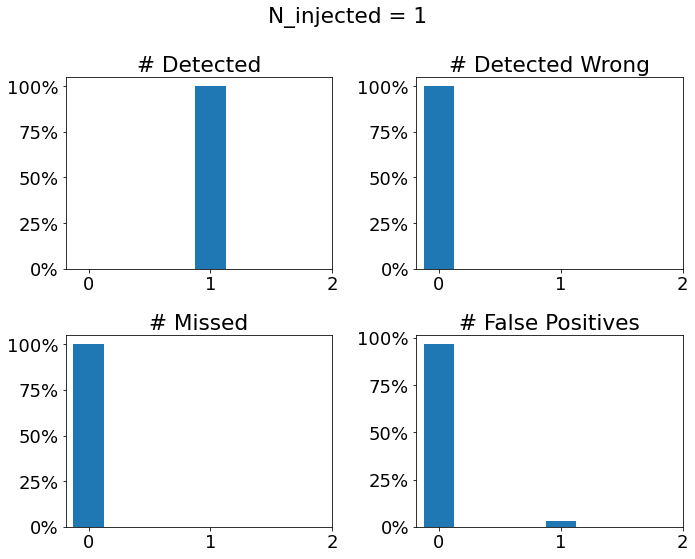

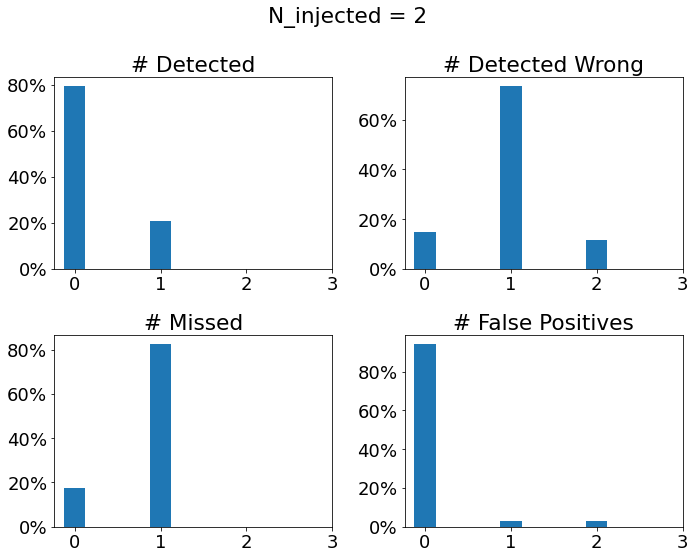

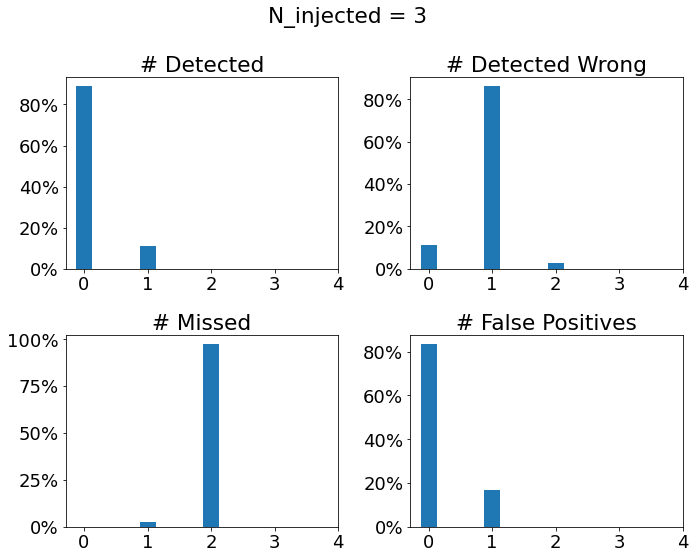

In [15]:
# Plot up a summary of the statistics for each of the light curves, sorted by number of flares injected.
for i in range(3):
    # Look for those light curves with this many injected flares (1, 2, or 3).
    n_inj_flares = i+1
    where_n_flares = np.where(all_n_in_visit == n_inj_flares)[0]
    these_n_det = all_n_det[where_n_flares]
    these_n_det_wrongenergy = all_n_det_wrongenergy[where_n_flares]
    these_n_miss = all_n_miss[where_n_flares]
    these_n_fp = all_n_fp[where_n_flares]
    fig, (ax_row1, ax_row2) = plt.subplots(2, 2, figsize=(10, 8))

    # Plot distribution of number of flares detected.
    ax_row1[0].set_title("# Detected")
    ax_row1[0].hist(these_n_det, bins=range(n_inj_flares+2), density=True, align='left', rwidth=0.25)
    ax_row1[0].set_xticks(range(n_inj_flares+2))
    ax_row1[0].yaxis.set_major_formatter(PercentFormatter(1))

    # Plot distribution of number of flares detected.
    ax_row1[1].set_title("# Detected Wrong")
    ax_row1[1].hist(these_n_det_wrongenergy, bins=range(n_inj_flares+2), density=True, align='left', rwidth=0.25)
    ax_row1[1].set_xticks(range(n_inj_flares+2))
    ax_row1[1].yaxis.set_major_formatter(PercentFormatter(1))
    
    # Plot distribution of number of flares missed.
    ax_row2[0].set_title("# Missed")
    ax_row2[0].hist(these_n_miss, bins=range(n_inj_flares+2), density=True, align='left', rwidth=0.25)
    ax_row2[0].set_xticks(range(n_inj_flares+2))
    ax_row2[0].yaxis.set_major_formatter(PercentFormatter(1))
    
    # Plot distribution of number of false positive detections.
    ax_row2[1].set_title("# False Positives")
    ax_row2[1].hist(these_n_fp, bins=range(n_inj_flares+2), density=True, align='left', rwidth=0.25)
    ax_row2[1].set_xticks(range(n_inj_flares+2))
    ax_row2[1].yaxis.set_major_formatter(PercentFormatter(1))
    
    fig.suptitle("N_injected = " + str(n_inj_flares))
    fig.tight_layout()

In [17]:
# Now we'll do a big run (we won't make any plots though.)
start_time = time.time()
random_seed = 42 # So that the exact results here when selecting random flare properties are repeatable.
rng = np.random.default_rng(seed=random_seed)
# How many flares to simulate here as an overview.
n_flares_to_make = 100000
# For each light curve, keep track of the number of flares detected, missed, and false positives.
all_n_det = np.asarray([0] * n_flares_to_make)
all_n_det_wrongenergy = np.asarray([0] * n_flares_to_make)
all_n_miss = np.asarray([0] * n_flares_to_make)
all_n_fp = np.asarray([0] * n_flares_to_make)
all_n_in_visit = np.asarray([0] * n_flares_to_make)
# If a detected flare is within "energy_match_factor" count it as detected, otherwise detected_wrongenergy.
energy_match_factor = 2.

for i in range(n_flares_to_make):
    # Generate flares with random properties within plausible ranges.
    # Randomly determine how many flares to inject into the Visit, between 1 and 'max_flares_pervisit'.
    n_in_visit = rng.choice(np.asarray(range(max_flares_pervisit))+1)
    all_n_in_visit[i] = n_in_visit
    # First: select a peak NUV magnitude from within a specified range.
    fpeak_mags = rng.uniform(low=13, high=18, size=n_in_visit)
    # Have the flare start at some random time during the visit (avoid edges since we don't count truncated flares in
    # the paper analysis either.
    tpeaks = rng.uniform(low=trange[0]+200, high=trange[1]-200, size=n_in_visit)
    # This will record whether a given flare is "detected".
    tpeaks_detected = np.asarray([0] * len(tpeaks))
    # This will record whether a given flare is "detected" but with the wrong energy.
    tpeaks_detected_wrongenergy = np.asarray([0] * len(tpeaks))
    # Now assign the flare a random full width at half maximum (FWHM).
    fwidths = rng.uniform(low=1, high=300, size=n_in_visit)
    
    # Generate the model flare.
    models, lc = fake_a_flare(band=band, quiescent_mag=quiescent_mag, fpeak_mags=fpeak_mags,
        stepsz=binsize, trange=trange, tpeaks=tpeaks, fwidths=fwidths, resolution=resolution)

    # Calculate the energies of the synthetic flares.
    model_energies = np.asarray([0.] * len(models))
    for mm, model in enumerate(models):
        model_energies[mm] = calculate_ideal_flare_energy(model, mag2counts(quiescent_mag, band), distance)
    
    # Determine the INFF based on the light curve generated.
    q, q_err = get_inff(lc)
    
    # Locate the flare range following the algorithm described in our paper.
    fr, quiescence, quiescence_err = refine_flare_ranges(lc, sigma=detection_threshold, makeplot=False)
    
    # Keep track of number of false positive flares detected.
    n_fp = 0
    for ff,f in zip(range(len(fr)), fr):
        energy, _ = calculate_flare_energy(lc, f, distance, band=band)
        # Note: no "uncertainty" needed in our quiescence measurement, so that's why the argument has "0.0" since
        # the function expects this to be passed as a two-element list containing q and q_err.
        energy_w_q, _ = calculate_flare_energy(lc, f, distance, band=band,
                         quiescence=[mag2counts(quiescent_mag, band), 0.0])

        # Locate start and stop of each detected flare range.
        fstart = lc.iloc[np.unique(f)]['t0'].iloc[0]
        fend = lc.iloc[np.unique(f)]['t0'].iloc[-1]
        # Locate the peak within each flare detected range.
        maxind = lc.iloc[np.unique(f)]['cps'].idxmax()
        fmax = lc.iloc[maxind]['t0']+binsize/2.
        # Is this detected flare peak within +/- 2 time bins from a known flare peak?
        where_close = np.where(abs(fmax-tpeaks) <= 2*binsize)[0]
        if len(where_close) == 1:
            # Simple match.
            # If energy is within a factor of "energy_match_factor" count as detection.
            if within_factor(energy_w_q, model_energies[where_close[0]], energy_match_factor):
                tpeaks_detected[where_close[0]] += 1
            else:
                # Otherwise count as "wrongenergy".
                tpeaks_detected_wrongenergy[where_close[0]] += 1
        elif len(where_close) > 1:
            # Choose the flare with the biggest energy (lowest mag) as the one detected.
            index_to_use = where_close[np.argmin(fpeak_mags[where_close])]
            # If energy is within a factor of "energy_match_factor" count as detection.
            if within_factor(energy_w_q, model_energies[index_to_use], energy_match_factor):
                tpeaks_detected[index_to_use] += 1
            else:
                # Otherwise count as "wrongenergy".
                tpeaks_detected_wrongenergy[index_to_use] += 1
        else:
            # Found a flare that isn't a real one.
            n_fp += 1
    # Make sure none of the injected flares was detected more than once.
    if len(np.where(tpeaks_detected > 1)[0]):
        raise ValueError("One of the injected flares was counted more than once as being detected.")
    # Count how many injected flares were found or missed.
    n_miss = len(np.where((tpeaks_detected == 0) & (tpeaks_detected_wrongenergy == 0))[0])
    n_det = len(np.where(tpeaks_detected == 1)[0])
    n_det_wrongenergy = len(np.where(tpeaks_detected_wrongenergy == 1)[0])
    # Update the arrays storing the results.
    all_n_det[i] = n_det
    all_n_det_wrongenergy[i] = n_det_wrongenergy
    all_n_miss[i] = n_miss
    all_n_fp[i] = n_fp
end_time = time.time()
print("Time taken to finish: " + str(end_time - start_time))

Time taken to finish: 4897.463596105576


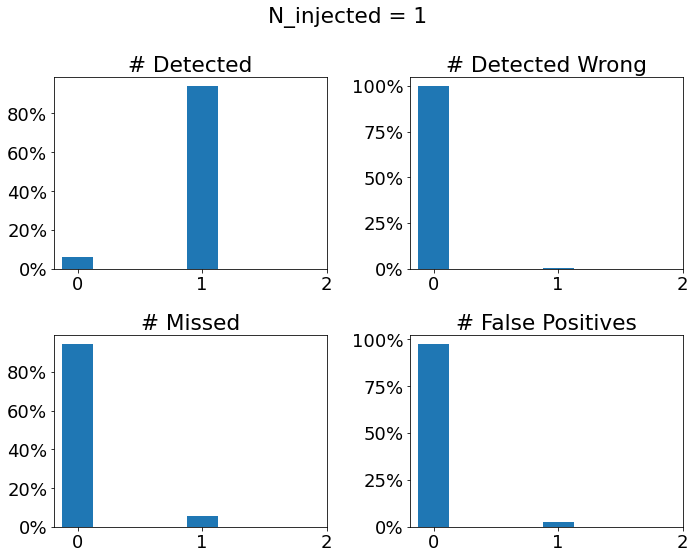

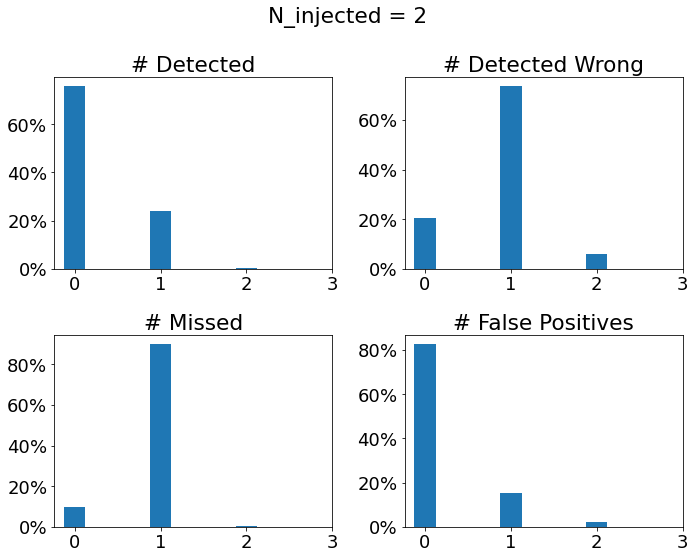

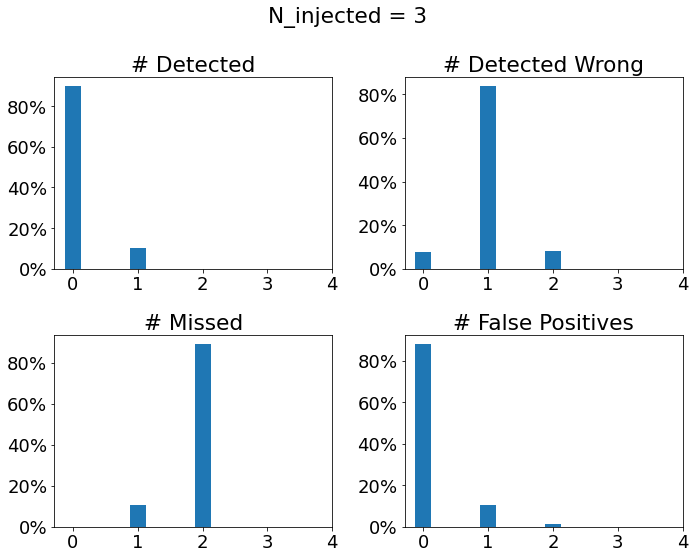

In [18]:
# Plot up a summary of the statistics for each of the light curves, sorted by number of flares injected.
for i in range(3):
    # Look for those light curves with this many injected flares (1, 2, or 3).
    n_inj_flares = i+1
    where_n_flares = np.where(all_n_in_visit == n_inj_flares)[0]
    these_n_det = all_n_det[where_n_flares]
    these_n_det_wrongenergy = all_n_det_wrongenergy[where_n_flares]
    these_n_miss = all_n_miss[where_n_flares]
    these_n_fp = all_n_fp[where_n_flares]
    fig, (ax_row1, ax_row2) = plt.subplots(2, 2, figsize=(10, 8))

    # Plot distribution of number of flares detected.
    ax_row1[0].set_title("# Detected")
    ax_row1[0].hist(these_n_det, bins=range(n_inj_flares+2), density=True, align='left', rwidth=0.25)
    ax_row1[0].set_xticks(range(n_inj_flares+2))
    ax_row1[0].yaxis.set_major_formatter(PercentFormatter(1))

    # Plot distribution of number of flares detected.
    ax_row1[1].set_title("# Detected Wrong")
    ax_row1[1].hist(these_n_det_wrongenergy, bins=range(n_inj_flares+2), density=True, align='left', rwidth=0.25)
    ax_row1[1].set_xticks(range(n_inj_flares+2))
    ax_row1[1].yaxis.set_major_formatter(PercentFormatter(1))
    
    # Plot distribution of number of flares missed.
    ax_row2[0].set_title("# Missed")
    ax_row2[0].hist(these_n_miss, bins=range(n_inj_flares+2), density=True, align='left', rwidth=0.25)
    ax_row2[0].set_xticks(range(n_inj_flares+2))
    ax_row2[0].yaxis.set_major_formatter(PercentFormatter(1))
    
    # Plot distribution of number of false positive detections.
    ax_row2[1].set_title("# False Positives")
    ax_row2[1].hist(these_n_fp, bins=range(n_inj_flares+2), density=True, align='left', rwidth=0.25)
    ax_row2[1].set_xticks(range(n_inj_flares+2))
    ax_row2[1].yaxis.set_major_formatter(PercentFormatter(1))
    
    fig.suptitle("N_injected = " + str(n_inj_flares))
    fig.tight_layout()

Stuff below here is old, probably delete in final version....

In [ ]:
redo = False
if redo:
    output = inject_and_recover(n=100000, omit_incompletes=True, detection_threshold=3)
    %store output
else:
    %store -r output
emin, emax = np.array(output['energy_true']).min(), np.array(output['energy_true']).max()
print("Min. and Max. Energy Flares Detected: " + str(emin) + ', ' + str(emax))

Let's see how well the flare energies are measured from the flare detection algorithm that includes an estimate of the INFF, compared to the energies measured with the (known) quiescent value. This tests the ability of the flare detection algorithm to derive accurate flare energies after estimating the quiescent value by comparing the flare energies derived with the perfect knowledge of what the simulated quiescent value is.

In [ ]:
# Divide the flare range into energy bins in log space.
bins = np.logspace(np.log10(emin), np.log10(emax), 50)

# We don't include any flares that didn't have an energy measured at all.
ix = np.where(np.array(output['energy_measured']) != 0)[0]

# Histogram of true (input) flare energies.
true_hist, _ = np.histogram(np.asarray(output['energy_true'][ix]), bins=bins)
# Histogram of measured flare energies allowing the flare detection to determine INFF.
meas_hist, _ = np.histogram(np.asarray(output['energy_measured'][ix]), bins=bins)
# Histogram of measured flare energies fixing the INFF to the known (input) quiescent level.
meas_hist_with_q, _ = np.histogram(np.asarray(output['energy_measured_w_q'][ix]), bins=bins)

# Let's make a plot showing these distributions and the difference with and without perfect knowledge of the
# INFF/quiescent value.
fig1 = plt.figure(figsize=(15, 6))
plt.plot(bins[:-1], true_hist, '-o', label='Input (Known) Energies')
plt.plot(bins[:-1], meas_hist, '-o', label='Detection Alg. w/ Meas. INFF')
plt.plot(bins[:-1], meas_hist_with_q, '-o', label='Detection Alg. w/ Known INFF')
plt.axvline(10**28.5, color='black', label='Low-End of GJ 65 Flares')
plt.semilogx()
# Nothing is detected below 10^27.5, so let's zoom in on the x-axis.
plt.xlim([10**27.5, emax])
plt.xlabel('Flare Energy')
plt.ylabel('Number of Detected Flares At This Energy')
plt.tight_layout()
plt.legend(loc="upper right")
plt.show()

# Let's look at the differences between the two energy measurements and the intput energies.
fig2 = plt.figure(figsize=(15, 6))

# Plot the differences between input energy and measured energies with and without known INFF values.
plt.plot(output['energy_true'][ix],
         (output['energy_true'][ix] - output['energy_measured'][ix])/output['energy_true'][ix], 'o',
         fillstyle='none', label="Meas. w/ Meas. INFF", color='orange', alpha=0.1)
plt.plot(output['energy_true'][ix],
         (output['energy_true'][ix] - output['energy_measured_w_q'][ix])/output['energy_true'][ix], 'o',
         fillstyle='none', label="Meas. w/ Known INFF", color='green', alpha=0.1)
plt.xlabel('Flare Energy')
plt.ylabel('(Input Energy - Meas. Energy) / Input Energy')
plt.semilogx()
# Nothing is detected below 10^27.5, so let's zoom in on the x-axis.
plt.xlim([10**27.5, emax])
# There are a very small number that differ by factors of a few, but hardly any, so let's zoom in on +/- 100%.
plt.ylim(-1., 1.1)
plt.tight_layout()
leg = plt.legend(loc="upper right")
for lh in leg.legendHandles: 
    lh._legmarker.set_alpha(1)
plt.show()

# Let's determine how many are within +/- 50% and +/- 75% of the input energy, since the goal here is to DETECT the
# flare, not necessarily measure the correct energy (uncertainties are measured and reported.)  This is because our
# energy bins are large (powers of ten), so a factor of ~2 in measured energy will not significantly impact the FFD
# when they are binned at the level of powers of 10.
n_factor_two = len(np.where(
    abs((np.asarray(output['energy_true'][ix]) - np.asarray(output['energy_measured'][ix]))/
        np.asarray(output['energy_true'][ix]))
                        <= 0.50)[0])
n_factor_four = len(np.where(
    abs((np.asarray(output['energy_true'][ix]) - np.asarray(output['energy_measured'][ix]))/
        np.asarray(output['energy_true'][ix]))
                        <= 0.75)[0])
print("Percent of measured energies (w/ INFF meas.) within 50% (factor of 2) of the input = {0:6.2f}%".format(
    n_factor_two / float(len(output['energy_true'][ix])) * 100.))
print("Percent of measured energies (w/ INFF meas.) within 75% (factor of 4) of the input = {0:6.2f}%".format(
    n_factor_four / float(len(output['energy_true'][ix])) * 100.))

# Let's examine how this ratio is for flares with energies between 10**28 to 10**29, since that's where the bulk
# of the detected GJ 65 flares reside.
n_factor_two_lowe = len(np.where(
    (np.asarray(abs((output['energy_true'][ix] - output['energy_measured'][ix])/
         output['energy_true'][ix])) <= 0.50) &
    (np.asarray(output['energy_true'][ix]) >= 10**28) &
    (np.asarray(output['energy_true'][ix]) <= 10**29)
                                )[0])

n_factor_four_lowe = len(np.where(
    (np.asarray(abs((output['energy_true'][ix] - output['energy_measured'][ix])/
         output['energy_true'][ix])) <= 0.75) &
    (np.asarray(output['energy_true'][ix]) >= 10**28) &
    (np.asarray(output['energy_true'][ix]) <= 10**29)
                                )[0])
n_28_29 = len(np.where(
    (np.asarray(output['energy_true'][ix]) >= 10**28) &
    (np.asarray(output['energy_true'][ix]) <= 10**29)
                      )[0])
print("Percent of meas. energies (w/ INFF meas.) where 28 < log(E) < 29, within 50% (factor of 2) of the input = {0:6.2f}%".format(
      n_factor_two_lowe / float(n_28_29) * 100.))
print("Percent of meas. energies (w/ INFF meas.) where 28 < log(E) < 29, within 75% (factor of 4) of the input = {0:6.2f}%".format(
      n_factor_four_lowe / float(n_28_29) * 100.))

Note that, at a 3-sigma detection, many flares below log(E) ~ 28 have much larger energies than the true values (top-panel).  Further examination shows performance is worst for flares with long durations and low peak energy.  Most likely this is due to confusion between the long tail of the flare and the noise level in the light curve, since the noise is closer to the flare amplitude at such low energies.  If the detection threshold is set to 5 sigma instead, and the entire set of simulated light curves is re-run, this population at low energies with very bad energy measurements disappears, since they become non-detected instead.  This is a strong argument for using a 5-sigma detection threshold when only a single band is available, but for GJ 65 we have dual-band measurements, and the energy range of the flares we can detect are at higher energies where such large systematics in the energy determinations are not present (log(E) > 28.5).

Now let's check what fraction of the flares are detected by our algorithm (regardless of the derived energy.

In [ ]:
# For this plot, we DO want to include simulated flares that we did NOT detect, so we won't filter out those
# non-detected flares with the "ix" mask.
true_hist, _ = np.histogram(np.asarray(output['energy_true']), bins=bins)

# Find all the flares where the energy was NOT measured, because the flare wasn't detected.
ix = np.where(np.array(output['energy_measured']) == 0)
# Compute the histogram across the bins.
non_hist, non_bins = np.histogram(np.array(output['energy_true'])[ix], bins=bins)
# What fraction out of the total did we miss in each bin?
fractional_nondetection = non_hist/true_hist

# Make a plot of the histogram of fractional non-detections with 10-90% recovery limits.
plt.figure(figsize=(15, 6))
plt.title('Recovery Rate vs. Energy')

# Plot of the number missed per energy bin.
plt.plot(non_bins[:-1], fractional_nondetection)

# What is the highest energy bin where we recover only ~10% of the flares?
p_gt_90 = non_bins[np.where(fractional_nondetection > 0.90)[0][-1]]

# Overplot the energies of the flares we find on GJ 65 that are used in the calculation of the flare frequency
# in the energy range log(E) 28.5 - 29.5.  This excludes the largest flare, as well as Flares 2, 10, and 12 in Table 1
# in the paper.
detected_flare_energies = [29.45, 28.88, 29.17, 28.95, 29.42, 28.73, 28.73, 29.05, 29.39, 29.06, 29.31]
for iii,dfe in enumerate(detected_flare_energies):
    if iii == 0:
        plt.vlines(10**dfe, 0, 1, label='Detected flare on GJ 65.', color='grey')
    else:
        plt.vlines(10**dfe, 0, 1, color='grey')

# What is the lowest energy bin where we recover up to 90% of the flares?
p_lt_10 = non_bins[np.where(fractional_nondetection < 0.10)[0][0]]

plt.semilogx()
plt.ylabel('Fractional Non-Detections')
plt.xlabel('Flare Model Energy (ergs)')
# Let's trim out the extreme low-energy bins where absolutely everything is missed.
# Upper x-axis plot range extends to upper limit of the energy bin in our paper: 28.5 < log(E) < 29.5
plt.xlim([non_bins[np.where(fractional_nondetection > 0.99)[0][-1]],
          10**29.5])
plt.tight_layout()
plt.legend()
plt.savefig('figures/flaredetect.eps', dpi=600)

# What is the number of flares with non-detections at the low-end of the bin used in the GJ 65 FFD calculation?
p_at_285 = np.interp(10**28.5, bins[:-1], fractional_nondetection)
print("Fraction of flares missed at log(E) = 28.5: {0:6.2f}%".format(p_at_285*100.))

# What is the number of flares with non-detections at the middle of the bin used in the GJ 65 FFD calculation?
p_at_29 = np.interp(10**29, bins[:-1], fractional_nondetection)
print("Fraction of flares missed at log(E) = 29: {0:6.2f}%".format(p_at_29*100.))

# What is the number of flares with non-detections at the high-end of the bin used in the GJ 65 FFD calculation?
p_at_295 = np.interp(10**29.5, bins[:-1], fractional_nondetection)
print("Fraction of flares missed at log(E) = 29.5: {0:6.2f}%".format(p_at_295*100.))

In [ ]:
# For those curious, this counts how many of the 100,000 simulated flares fell within the energy range near our GJ 65
# flare frequency estimation.
len(np.where( 
    (np.asarray(output['energy_true']) > 10**28) &
    (np.asarray(output['energy_true']) < 10**30)
)[0])